In [ ]:
%pip install PyTDC

In [ ]:
%pip install rdkit

In [ ]:
%pip install pandas-flavor

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #progress bar
import rdkit
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
rdkit.__version__

import xgboost as xgb
import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import fbeta_score, make_scorer
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split #ML training
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error #ML stats
from yellowbrick.regressor import prediction_error, ResidualsPlot
from tdc.single_pred import ADME
from tdc.benchmark_group import admet_group
from tdc import BenchmarkGroup
import warnings
warnings.filterwarnings("ignore")

In [ ]:
group = admet_group(path = 'data/')
predictions_list_xgb = []
best_params_list_xgb = []
predictions_list_rf = []
predictions_list_svm = []
best_params_list_svm = []
predictions_list_adb = []
predictions_list_cnn = []

for seed in [1, 2, 3, 4, 5]:
    predictions_xgb = {}
    predictions_rf = {}
    predictions_svm = {}
    predictions_adb = {}
    predictions_cnn = {}

    benchmark = group.get('LD50_Zhu')
    name = benchmark['name']
    train_val, test = benchmark['train_val'], benchmark['test']
    train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = seed)

    PandasTools.AddMoleculeColumnToFrame(train, smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in train['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = train['Y']
    train = pd.DataFrame(ecfp6_bits, index = train.Drug, columns=ecfp6_name).reset_index(drop = False)
    train['Y'] = Y

    PandasTools.AddMoleculeColumnToFrame(benchmark['test'], smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in benchmark['test']['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = benchmark['test']['Y']
    benchmark['test'] = pd.DataFrame(ecfp6_bits, index = benchmark['test'].Drug, columns=ecfp6_name).reset_index(drop = False)
    benchmark['test']['Y'] = Y

    train_X = train.drop(columns = ["Drug","Y"])
    train_y = train.Y
    test_X = benchmark['test'].drop(columns = ["Drug","Y"])
    test_y = benchmark['test'].Y


    #XGBoost + Morgan
    xgb_parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.1],
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [300,400,500,600],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]}

    xgb_model = XGBRegressor()
    grid_obj_xgb = RandomizedSearchCV(xgb_model, xgb_parameters, cv=5, n_iter=15, scoring='neg_mean_absolute_error', verbose=5, n_jobs=1)
    grid_obj_xgb.fit(train_X, train_y, verbose = 1)
    y_pred_test_xgb = grid_obj_xgb.predict(test_X)
    bp_xgb = grid_obj_xgb.best_params_
    predictions_xgb[name] = y_pred_test_xgb
    predictions_list_xgb.append(predictions_xgb)
    best_params_list_xgb.append(bp_xgb)

    #Random Forest + Morgan
    rf_model = RandomForestRegressor()
    rf_model.fit(train_X, train_y)
    y_pred_test_rf = rf_model.predict(test_X)
    predictions_rf[name] = y_pred_test_rf
    predictions_list_rf.append(predictions_rf)

    #SVM + Morgan
    svm_parameters = {
        'C': [0.1, 1, 10, 100, 1000],
        'epsilon': [0.0001, 0.001, 0.01, 0.1, 0.5],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    }
    svm_model = SVR(kernel="rbf")
    grid_obj_svm = RandomizedSearchCV(svm_model, svm_parameters, cv=5, n_iter=15, scoring='neg_mean_absolute_error', verbose=5, n_jobs=1)
    grid_obj_svm.fit(train_X, train_y)
    y_pred_test_svm = grid_obj_svm.predict(test_X)
    bp_svm = grid_obj_svm.best_params_
    predictions_svm[name] = y_pred_test_svm
    predictions_list_svm.append(predictions_svm)
    best_params_list_svm.append(bp_svm)

    # AdaBoost + Morgan
    DTR = DecisionTreeRegressor(max_depth=4)
    adb_model = AdaBoostRegressor(n_estimators=300, base_estimator=DTR, learning_rate=1)
    adb_model.fit(train_X, train_y)
    y_pred_test_adb = adb_model.predict(test_X)
    predictions_adb[name] = y_pred_test_adb
    predictions_list_adb.append(predictions_adb)

    #CNN + Morgan
    train_X = train_X.to_numpy()
    test_X = test_X.to_numpy()
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
    cnn_model = Sequential()
    cnn_model.add(Conv1D(32, 2, activation="relu", input_shape=(1024,1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64, activation="relu"))
    cnn_model.add(Dense(1))
    cnn_model.compile(loss="mse", optimizer="adam")
    cnn_model.fit(train_X, train_y, batch_size=12, epochs=10, verbose=0)
    y_pred_test_cnn = cnn_model.predict(test_X)
    predictions_cnn[name] = y_pred_test_cnn
    predictions_list_cnn.append(predictions_cnn)

xgb_results = group.evaluate_many(predictions_list_xgb)
rf_results = group.evaluate_many(predictions_list_rf)
svm_results = group.evaluate_many(predictions_list_svm)
adb_results = group.evaluate_many(predictions_list_adb)
cnn_results = group.evaluate_many(predictions_list_cnn)



In [ ]:
xgb_results

In [ ]:
rf_results

In [ ]:
svm_results

In [ ]:
adb_results

In [ ]:
cnn_results

In [ ]:
predictions_list_cnn = [{'ld50_zhu': np.array([2.0026138,
         1.7986585,
         2.9981089,
         3.0686316,
         3.8388722,
         2.090396 ,
         2.2879548,
         2.8510878,
         2.2531986,
         2.4332154,
         2.535654 ,
         3.6609612,
         4.043643 ,
         4.621503 ,
         2.768337 ,
         3.1019573,
         2.637579 ,
         3.0558   ,
         3.7334392,
         3.446546 ,
         3.8693733,
         4.6480427,
         3.7318325,
         4.0747848,
         2.479217 ,
         2.8242517,
         4.7000318,
         4.7000318,
         4.402428 ,
         4.402428 ,
         2.0195918,
         2.7799857,
         1.9492906,
         2.1976588,
         1.8653744,
         2.4750075,
         2.7670097,
         2.1942656,
         2.1708262,
         2.247559 ,
         2.5046058,
         2.190959 ,
         2.8856485,
         3.2474647,
         2.4936602,
         2.0658686,
         1.650114 ,
         2.344823 ,
         2.1046288,
         2.2038147,
         1.913054 ,
         2.9534588,
         3.023042 ,
         1.7040437,
         2.5906076,
         2.0391996,
         2.5105143,
         2.8908987,
         2.3169966,
         1.9860226,
         2.7497602,
         2.387164 ,
         2.6385493,
         2.1559358,
         2.9343238,
         3.1994884,
         2.4762888,
         2.8307335,
         3.0948033,
         2.9968991,
         2.7832384,
         2.712617 ,
         2.540689 ,
         2.91664  ,
         3.1090438,
         2.3682423,
         2.3710604,
         3.0576415,
         2.298486 ,
         3.357857 ,
         2.56485  ,
         2.8749645,
         3.6818404,
         3.2581353,
         2.87418  ,
         2.9760404,
         2.796547 ,
         2.641533 ,
         2.6028926,
         2.7771997,
         3.1487923,
         2.9448502,
         2.673571 ,
         2.9932432,
         2.1974597,
         2.0552628,
         3.1179788,
         3.5396907,
         2.462139 ,
         2.9750595,
         3.0219445,
         2.8954065,
         2.7045386,
         3.2749693,
         2.8372307,
         2.5361996,
         2.1444902,
         2.8013148,
         2.9609265,
         2.505277 ,
         2.9715495,
         2.789834 ,
         2.5265276,
         2.6504471,
         3.0544486,
         2.2762575,
         3.0420465,
         4.0198684,
         2.4180949,
         3.2222703,
         2.8271828,
         2.474357 ,
         2.9776475,
         3.019793 ,
         2.6680462,
         3.5318785,
         3.193752 ,
         2.5374825,
         2.6542656,
         3.0901248,
         3.1609812,
         2.8676176,
         2.5581994,
         3.0902047,
         4.1887364,
         2.7959447,
         2.7534776,
         3.1304293,
         3.7485166,
         3.5840344,
         3.5140061,
         3.2273562,
         2.8471878,
         3.248515 ,
         3.1094007,
         3.1034496,
         2.8808267,
         2.5353024,
         3.2659829,
         2.287708 ,
         2.4472609,
         2.467663 ,
         2.7898593,
         3.5490263,
         2.2847729,
         2.9649644,
         2.7622309,
         2.5689075,
         3.8987768,
         3.0771067,
         3.0855448,
         4.0088134,
         2.7501001,
         3.1355903,
         2.8879328,
         2.838147 ,
         2.9500194,
         2.472172 ,
         3.1088347,
         3.1295137,
         2.9854207,
         2.659685 ,
         3.0457425,
         2.683476 ,
         3.2226233,
         2.5838008,
         2.211179 ,
         3.144696 ,
         2.9249048,
         2.188973 ,
         2.5813537,
         2.5129414,
         2.7555242,
         1.7422203,
         2.2654762,
         2.980079 ,
         3.2503326,
         3.3676448,
         2.7430627,
         3.3081856,
         3.2989316,
         3.1129909,
         2.5792136,
         2.5770764,
         3.0900712,
         2.882413 ,
         2.6839411,
         4.245753 ,
         2.5568016,
         1.9824578,
         1.860469 ,
         1.7778157,
         1.7153147,
         2.433384 ,
         4.4066677,
         3.4166667,
         4.2916136,
         3.714027 ,
         2.6017241,
         3.5082364,
         3.2655354,
         3.6675074,
         2.277985 ,
         2.2846541,
         2.6907446,
         2.707734 ,
         2.9764874,
         1.2744952,
         1.8813789,
         1.888949 ,
         2.2643366,
         1.93568  ,
         2.3136797,
         1.5782098,
         2.1115348,
         3.7708607,
         3.0979757,
         1.9507824,
         1.7673532,
         2.8422399,
         1.8043715,
         3.0111523,
         2.1510406,
         2.6307194,
         1.7662507,
         2.237479 ,
         1.6583251,
         2.818184 ,
         2.198055 ,
         2.527018 ,
         2.409524 ,
         1.438785 ,
         2.0598707,
         2.376119 ,
         2.776444 ,
         2.5270467,
         2.8068535,
         2.4976783,
         2.2441678,
         2.4695263,
         1.8721634,
         2.3962533,
         2.3942053,
         1.8796731,
         6.322603 ,
         5.1679277,
         2.8760781,
         2.7538326,
         1.6230596,
         2.7300935,
         1.4036366,
         1.2774941,
         3.441602 ,
         2.5032797,
         2.8285546,
         2.557232 ,
         2.7434258,
         2.6389782,
         2.6977317,
         1.9667925,
         1.5375748,
         1.9399081,
         1.8416837,
         2.4698882,
         2.4733224,
         1.7699229,
         2.5637822,
         2.1582613,
         1.7517196,
         1.6841637,
         1.7097822,
         1.6956999,
         1.5612881,
         1.7740731,
         1.8044789,
         2.4885752,
         1.3612388,
         1.6193796,
         2.3530319,
         3.0960915,
         3.0198717,
         1.2902321,
         1.8161808,
         2.1555948,
         2.300045 ,
         2.5157373,
         3.0796573,
         1.5203025,
         1.575587 ,
         2.0592337,
         1.6594441,
         1.9361163,
         2.303358 ,
         2.390161 ,
         2.0049582,
         2.3817246,
         2.1657717,
         2.168401 ,
         1.8883641,
         3.3581085,
         2.097602 ,
         3.2512689,
         2.6042936,
         2.3537204,
         2.4500735,
         2.5841005,
         1.9899418,
         2.0346248,
         3.1641548,
         2.434549 ,
         2.4610062,
         2.1003468,
         1.6645826,
         1.7827533,
         2.3851712,
         1.6945871,
         1.5544348,
         2.1830208,
         2.5354893,
         1.3934888,
         1.8582147,
         2.3102734,
         2.5124831,
         1.1642736,
         1.8275379,
         1.6863762,
         2.1922386,
         2.7144241,
         2.3399463,
         2.4610534,
         2.1972437,
         2.5988648,
         2.4889164,
         3.1193194,
         2.8709965,
         1.701727 ,
         2.2416282,
         2.4622946,
         2.4902282,
         2.459461 ,
         1.5086704,
         2.6152458,
         1.6767088,
         2.5717325,
         2.5334198,
         2.6434083,
         2.7741292,
         2.7279534,
         2.367027 ,
         2.4705641,
         2.62979  ,
         2.4939508,
         2.1175544,
         1.8943604,
         2.142527 ,
         2.519572 ,
         2.718495 ,
         2.7681537,
         1.5437568,
         2.635663 ,
         2.4693797,
         2.2219362,
         1.6205995,
         2.1790893,
         2.0855265,
         4.216245 ,
         2.1254215,
         2.1218302,
         2.3628879,
         2.6007342,
         3.214536 ,
         2.5291622,
         2.955525 ,
         2.5889044,
         3.214536 ,
         2.2974768,
         2.532968 ,
         2.887567 ,
         2.8412578,
         2.428919 ,
         2.7635696,
         3.0626607,
         2.1409218,
         2.2292717,
         2.819911 ,
         1.8911597,
         2.5032783,
         1.8127394,
         2.8425443,
         1.5725125,
         2.4573305,
         2.157445 ,
         2.5080988,
         1.5916559,
         1.6229637,
         3.1770132,
         3.206389 ,
         2.9105752,
         3.5418158,
         2.3016944,
         2.0291536,
         1.57731  ,
         2.2960804,
         2.9053261,
         2.2913744,
         3.309174 ,
         2.502368 ,
         2.5279746,
         3.0116043,
         2.2276664,
         3.4982328,
         2.2786195,
         1.5576304,
         1.7150688,
         3.4599857,
         3.1665244,
         3.3100698,
         2.6610122,
         3.1438186,
         2.6913145,
         1.9327846,
         1.6957105,
         1.7714068,
         1.8100411,
         1.7886099,
         1.6688691,
         1.5826265,
         2.3945308,
         2.1205342,
         2.3907986,
         2.7620552,
         2.541525 ,
         1.6353527,
         1.821023 ,
         2.1219158,
         2.8626487,
         1.822153 ,
         2.9094534,
         2.9520674,
         3.1339662,
         3.377716 ,
         2.2154024,
         3.05075  ,
         3.029538 ,
         2.7405062,
         2.6476605,
         2.7892313,
         4.3426456,
         3.3199334,
         2.5955014,
         2.7794435,
         1.9724461,
         1.8818222,
         2.3603   ,
         1.9585245,
         1.5929209,
         1.8957627,
         1.9147433,
         2.1357923,
         2.6767979,
         3.1422324,
         2.1193051,
         1.5434341,
         2.65177  ,
         2.065382 ,
         1.6203023,
         2.2435029,
         2.92377  ,
         2.887252 ,
         2.0231543,
         1.7393476,
         2.51542  ,
         1.6147912,
         2.329702 ,
         1.3395097,
         2.9240751,
         2.138392 ,
         2.116257 ,
         1.6975456,
         3.2875278,
         2.707151 ,
         1.8856735,
         2.0255482,
         2.4133081,
         1.2241534,
         3.3993654,
         2.5112064,
         2.95466  ,
         1.3915365,
         2.155085 ,
         2.0415335,
         2.546513 ,
         2.0969572,
         2.821849 ,
         2.812745 ,
         2.0632052,
         3.3683634,
         4.472085 ,
         3.3254712,
         4.4364867,
         3.0633621,
         2.578041 ,
         3.7476964,
         2.7883284,
         2.6758513,
         3.5617757,
         2.83528  ,
         3.1353407,
         2.0618515,
         2.757304 ,
         2.5633855,
         2.5768547,
         2.8769011,
         1.921621 ,
         2.5267482,
         2.1360579,
         2.2162282,
         1.7973874,
         1.8267051,
         2.4104865,
         2.5873013,
         1.4029418,
         2.1826398,
         3.5268424,
         2.0183985,
         2.5935302,
         2.0728445,
         1.7263588,
         1.8393029,
         2.0168533,
         2.0497925,
         1.9639777,
         2.003047 ,
         2.0904636,
         2.6277626,
         1.7321768,
         3.1049607,
         2.2049809,
         2.0992296,
         2.0926151,
         2.173438 ,
         2.3566813,
         2.5338173,
         2.1362028,
         2.0180573,
         2.9232996,
         2.3185759,
         1.8026531,
         2.1665435,
         1.4084654,
         2.511807 ,
         1.9780637,
         2.923331 ,
         2.3502078,
         3.0231192,
         1.8026531,
         3.209066 ,
         1.996853 ,
         2.1993716,
         2.4114215,
         1.9304421,
         1.9075625,
         1.9428912,
         1.9868695,
         1.8832835,
         2.6045146,
         2.6777875,
         2.3781054,
         2.4590864,
         2.450857 ,
         2.1113105,
         2.5902343,
         2.117079 ,
         2.4026358,
         2.9978194,
         2.8498082,
         3.0483367,
         2.5045633,
         2.9020007,
         3.0527601,
         3.2134662,
         3.2459772,
         3.0715418,
         1.8658565,
         1.6245279,
         2.464459 ,
         3.0355186,
         2.1800196,
         2.9690623,
         2.0498736,
         2.1097972,
         2.4861233,
         2.6646817,
         3.1862388,
         2.4267797,
         2.5177362,
         4.7909064,
         3.548882 ,
         2.792703 ,
         2.4607038,
         2.0320373,
         1.714558 ,
         2.7404573,
         1.4509735,
         1.5173321,
         2.104461 ,
         2.1887183,
         2.8082964,
         2.779661 ,
         3.00378  ,
         2.6963127,
         1.6760378,
         1.4823476,
         2.0852976,
         1.7426562,
         4.484848 ,
         4.0281515,
         4.4097137,
         3.8786678,
         2.8847523,
         2.4120324,
         2.55513  ,
         2.8540907,
         2.2267416,
         2.8482985,
         2.696381 ,
         2.1964626,
         2.5688272,
         1.7070755,
         1.6134335,
         2.8670936,
         2.5495138,
         2.1175358,
         2.7204804,
         2.4895732,
         2.5214357,
         2.4647622,
         2.645147 ,
         1.8523635,
         1.7837073,
         2.054666 ,
         1.941599 ,
         2.1164453,
         2.0599377,
         2.4021482,
         3.3935924,
         1.4136456,
         2.3794336,
         2.2371414,
         1.5607833,
         1.7986647,
         1.964742 ,
         2.3473883,
         1.9486876,
         2.5019326,
         3.048367 ,
         2.893446 ,
         2.620509 ,
         2.3885083,
         2.4356046,
         2.3792064,
         2.5774846,
         1.8059882,
         1.8673335,
         3.9854689,
         2.596561 ,
         2.509223 ,
         2.4878402,
         2.2262664,
         2.7650266,
         2.7908428,
         2.3485794,
         3.375339 ,
         2.9991503,
         3.2007618,
         2.9583395,
         2.1855755,
         2.142521 ,
         2.496556 ,
         2.1089847,
         3.1111102,
         2.6825922,
         2.959048 ,
         3.340564 ,
         2.431868 ,
         2.6806   ,
         3.0259366,
         2.3669152,
         1.7310477,
         2.2877822,
         2.27002  ,
         2.1060443,
         1.799415 ,
         3.3653393,
         2.7222085,
         2.4640255,
         1.5242437,
         2.5352678,
         2.4225187,
         2.784064 ,
         2.7386146,
         1.9863864,
         3.115455 ,
         1.9501891,
         1.7596902,
         2.2433622,
         1.9966425,
         1.8725555,
         3.1107435,
         2.8705065,
         2.1541348,
         1.4869322,
         1.7982744,
         1.817332 ,
         2.2193737,
         2.5444844,
         2.331402 ,
         1.8441502,
         2.117201 ,
         1.7269958,
         2.3265815,
         2.0990222,
         2.1034122,
         2.9864578,
         4.2205124,
         1.9402938,
         2.1608782,
         2.1447055,
         2.034156 ,
         2.2293375,
         1.8457261,
         2.74011  ,
         1.9194211,
         2.238893 ,
         1.7884948,
         2.7290382,
         1.8934923,
         2.3248432,
         2.336703 ,
         2.4725199,
         2.38651  ,
         1.724809 ,
         2.3328087,
         4.383266 ,
         1.852528 ,
         2.2374518,
         2.0312   ,
         2.2959685,
         1.4047784,
         2.6584778,
         1.7386676,
         1.8272116,
         1.7068424,
         2.3220658,
         2.7181454,
         3.5178797,
         2.3421674,
         2.7571564,
         1.7255367,
         2.1565728,
         1.9668849,
         2.060483 ,
         1.8031783,
         2.1248944,
         2.4942155,
         2.2278576,
         1.8925852,
         1.9360161,
         2.6797733,
         2.0241725,
         2.10045  ,
         2.180788 ,
         3.0411077,
         2.915217 ,
         1.6185486,
         2.125611 ,
         1.7900867,
         2.2220836,
         2.8459191,
         2.9411478,
         1.7548276,
         1.8858014,
         1.7329572,
         2.5930657,
         2.4485135,
         3.1862345,
         1.4285896,
         2.168968 ,
         2.7999756,
         2.692472 ,
         2.7125654,
         2.7333314,
         2.9412887,
         2.250338 ,
         2.0361803,
         2.1649337,
         3.799707 ,
         2.2578926,
         4.2933717,
         1.866364 ,
         2.5226395,
         2.0911891,
         2.0471208,
         2.0562997,
         1.3969004,
         2.7668808,
         4.113739 ,
         3.6601176,
         2.6542697,
         2.2206845,
         2.62645  ,
         1.4159213,
         1.8681618,
         2.0709536,
         1.8443894,
         2.2901466,
         1.8557249,
         2.698634 ,
         2.199625 ,
         3.135641 ,
         2.1043353,
         3.071868 ,
         1.7561744,
         2.5146139,
         2.658174 ,
         3.1850736,
         3.3061562,
         2.236304 ,
         1.8263503,
         2.0431228,
         2.2580833,
         1.8061129,
         2.1196442,
         1.4564339,
         1.9696264,
         1.5421451,
         3.667183 ,
         2.0438807,
         2.422442 ,
         1.6398369,
         2.618986 ,
         1.4473418,
         1.4612026,
         1.221269 ,
         1.2600517,
         1.615919 ,
         2.654348 ,
         1.6871786,
         2.2503443,
         1.9623772,
         2.0636008,
         3.6038322,
         3.0112524,
         2.0222392,
         2.5623434,
         1.7751395,
         2.4362054,
         2.5502484,
         1.8694347,
         2.566017 ,
         2.2790954,
         2.3754158,
         2.5497112,
         2.3924546,
         3.6046696,
         2.590487 ,
         1.9652582,
         2.753352 ,
         2.8338614,
         2.2300062,
         2.991292 ,
         2.4343073,
         2.8044589,
         2.545004 ,
         2.0063179,
         3.1617799,
         2.160251 ,
         1.9658777,
         2.9823072,
         4.0368147,
         2.7081459,
         3.0142653,
         2.0093098,
         2.2150419,
         1.8021959,
         3.3407347,
         2.3286762,
         1.5857319,
         2.2877977,
         2.2903523,
         2.2476835,
         2.183846 ,
         1.720088 ,
         2.621716 ,
         2.103699 ,
         1.8853351,
         2.8812292,
         2.895423 ,
         3.497581 ,
         2.1277163,
         2.6132889,
         2.8483448,
         2.550007 ,
         2.2300062,
         2.3697214,
         1.933477 ,
         2.4005942,
         3.1786308,
         2.618134 ,
         2.2393937,
         3.413223 ,
         2.9374976,
         2.8640027,
         2.4944031,
         3.88831  ,
         2.4597   ,
         2.042758 ,
         2.7956629,
         1.847609 ,
         3.7432091,
         3.27162  ,
         2.6056862,
         2.7628095,
         2.6911275,
         3.610704 ,
         1.7618026,
         2.9990423,
         3.2361104,
         1.734553 ,
         2.2797904,
         2.098354 ,
         1.5892895,
         2.1449845,
         1.7262483,
         2.343653 ,
         2.6419797,
         2.57227  ,
         2.421744 ,
         2.632542 ,
         1.8514931,
         1.3043448,
         1.7548493,
         4.2448864,
         3.3391774,
         1.7874641,
         1.8898304,
         1.553736 ,
         1.5717715,
         2.3681276,
         3.9881725,
         3.4643254,
         2.7569556,
         2.832232 ,
         2.7576396,
         1.9744389,
         2.3189144,
         1.8143317,
         2.1154482,
         1.6412705,
         2.7331834,
         2.449025 ,
         1.5344462,
         2.6779842,
         1.9586271,
         1.7104598,
         1.5885977,
         2.5385027,
         1.9344939,
         1.8470176,
         2.2715921,
         3.3536339,
         1.9364315,
         2.0610902,
         2.3563871,
         2.358422 ,
         2.578775 ,
         1.4700463,
         2.9147086,
         1.5740715,
         2.2330854,
         1.5183008,
         1.6046833,
         1.6859848,
         2.5639644,
         2.157978 ,
         1.685337 ,
         1.919286 ,
         1.7018684,
         2.3844264,
         1.7527236,
         1.4987997,
         3.066227 ,
         1.8211935,
         2.1507561,
         3.1540947,
         1.1959673,
         2.4297028,
         1.7474808,
         1.4688274,
         2.0550675,
         2.8020992,
         1.9961349,
         1.33186  ,
         1.8415521,
         1.6640848,
         1.8908908,
         1.7897712,
         1.567227 ,
         2.2102895,
         1.794744 ,
         1.9007338,
         1.5616443,
         1.7312375,
         2.172441 ,
         1.9916991,
         3.6586547,
         2.4410331,
         1.3947252,
         3.0093393,
         2.2490606,
         2.0615416,
         1.5777563,
         1.8637649,
         1.4755355,
         1.9376549,
         2.591491 ,
         2.0976834,
         2.5079427,
         2.7887688,
         2.203837 ,
         1.9184281,
         2.9965537,
         3.0935397,
         2.0640316,
         2.2171948,
         2.267758 ,
         2.8551178,
         2.535799 ,
         2.5839422,
         1.5034984,
         2.6109915,
         3.4992595,
         3.4616365,
         1.9541775,
         1.4667406,
         2.1370285,
         1.4667408,
         1.4667408,
         2.1852756,
         1.559755 ,
         2.7208166,
         1.8238373,
         1.8238373,
         1.7831981,
         1.1978372,
         2.0114286,
         2.4002337,
         1.9528066,
         2.9811962,
         1.8236598,
         2.492829 ,
         3.257925 ,
         2.6885962,
         2.1461222,
         2.0145373,
         2.1504748,
         1.6770276,
         2.2104452,
         2.5984323,
         2.533998 ,
         2.3588529,
         2.6282654,
         2.7254977,
         2.3283782,
         3.2516313,
         2.6839688,
         1.6443675,
         2.5257144,
         2.6474996,
         2.0282352,
         1.9527289,
         3.9714932,
         1.8470176,
         1.8044674,
         2.5888205,
         2.671982 ,
         2.0184941,
         1.5987264,
         2.077244 ,
         1.5741457,
         2.7012005,
         1.8256799,
         2.620792 ,
         2.746669 ,
         2.2888448,
         2.2282076,
         2.3929334,
         3.2671328,
         3.5732112,
         3.1262367,
         3.3730328,
         2.2238255,
         2.9974995,
         2.0415418,
         3.0247188,
         2.2586687,
         2.6314483,
         2.588902 ,
         4.6478343,
         1.9469361,
         2.811256 ,
         2.4757795,
         1.7915723,
         2.6296697,
         1.8893493,
         2.2706463,
         1.6469923,
         2.0793347,
         1.684687 ,
         1.6159855,
         2.3412342,
         1.9406295,
         2.1342459,
         2.8117094,
         1.7406245,
         2.3186035,
         2.0298994,
         1.9212246,
         2.2184973,
         2.0907016,
         2.2510333,
         1.8998702,
         1.8769584,
         2.3830142,
         2.3687823,
         3.785254 ,
         3.9158022,
         3.3644552,
         2.9284718,
         3.1156301,
         2.3624127,
         1.7975999,
         1.0082096,
         2.658592 ,
         2.6313229,
         2.191857 ,
         1.7574216,
         2.497355 ,
         2.7148807,
         2.5609748,
         3.2943099,
         2.6414387,
         1.9350245,
         2.4091702,
         2.2022896,
         3.8343005,
         2.2689996,
         4.008512 ,
         2.0108705,
         1.9616092,
         3.209949 ,
         2.791165 ,
         2.4411454,
         3.163843 ,
         2.6280608,
         2.5224283,
         2.9699886,
         3.141298 ,
         2.8604493,
         2.8718896,
         2.3154082,
         3.3785174,
         3.6937478,
         2.850334 ,
         2.6281264,
         2.7842712,
         1.6776906,
         1.8794427,
         3.6937473,
         3.6602178,
         2.6710615,
         1.9047842,
         1.8438872,
         3.655192 ,
         2.709312 ,
         2.1719327,
         2.4385529,
         2.8002732,
         2.0045736,
         2.0045736,
         1.8291426,
         1.7948685,
         2.7497046,
         2.3040965,
         2.200368 ,
         2.0997272,
         2.3414378,
         3.2298577,
         2.3116362,
         2.6747978,
         3.732904 ,
         2.0691   ,
         2.2806745,
         2.5130434,
         1.9481108,
         2.44584  ,
         2.1715438,
         2.3440015,
         1.7278744,
         2.2434347,
         2.5048482,
         2.1635208,
         2.5142024,
         2.4021528,
         2.0523968,
         2.5923564,
         3.062377 ,
         2.1012893,
         2.4235702,
         2.1012225,
         2.113919 ,
         2.6747136,
         2.633636 ,
         2.6529982,
         2.7832117,
         2.1794586,
         3.1145902,
         2.0447245,
         2.1248844,
         1.9734807,
         3.1251426,
         2.4836895,
         2.7864537,
         2.5222807,
         2.2930517,
         1.8214177,
         2.1475332,
         3.7281637,
         2.675304 ,
         1.8597416,
         1.8304085,
         2.1492367,
         2.3922458,
         2.229232 ,
         1.9792432,
         1.5858812,
         3.2054648,
         2.6681952,
         1.8738866,
         2.0882468,
         2.053249 ,
         2.6782994,
         2.2644753,
         2.1071992,
         2.6618702,
         2.3888872,
         1.965675 ,
         2.7460155,
         2.2752352,
         3.2064934,
         3.0941136,
         1.9070446,
         2.4839544,
         2.0728896,
         2.1276186,
         2.4077163,
         3.0531554,
         1.7495875,
         1.8451093,
         2.8829837,
         2.471297 ,
         2.334193 ,
         1.7794238,
         2.4177663,
         1.8219267,
         1.7028538,
         1.7187726,
         2.7353287,
         2.1350346,
         2.3740375,
         2.052904 ,
         2.2125218,
         2.6058445,
         2.6407971,
         2.0151722,
         2.9070396,
         2.0936713,
         2.3834376,
         1.9687963,
         2.8439436,
         3.8279681,
         3.1637497,
         4.6787553,
         4.0352473,
         4.0305915,
         3.6801963,
         3.1318555,
         3.6539476,
         3.7896998,
         3.8187213,
         4.217986 ,
         3.0621424,
         3.377331 ,
         3.8273082,
         4.650162 ,
         3.7092443,
         4.070516 ,
         3.7695527,
         3.5470228,
         3.2559912,
         3.6050866,
         3.5956209,
         4.184934 ,
         2.888648 ,
         3.805248 ,
         3.022951 ,
         3.7534556,
         3.3540545,
         3.2405696,
         3.6426973,
         2.9497752,
         3.7558343,
         2.9956837,
         2.8371115,
         3.3843265,
         3.086052 ,
         4.0262866,
         3.0041122,
         3.0511892,
         4.296873 ,
         4.511554 ,
         2.3532755,
         3.3422081,
         2.992901 ,
         3.7046542,
         2.403657 ,
         3.7588563,
         3.8612504,
         3.3591108,
         3.8304443,
         3.6173234,
         3.594091 ,
         3.4007983,
         5.063809 ,
         3.9424531,
         4.3641067,
         2.655263 ,
         2.1568   ,
         2.965496 ,
         3.0666053,
         2.4553106,
         3.7237058,
         2.944176 ,
         2.8647685,
         2.3869328,
         1.9274001,
         1.7441742,
         1.3146979,
         2.4820833,
         2.6572137,
         1.4241457,
         1.1301249,
         1.9598784,
         1.2024603,
         1.6748165,
         2.093538 ,
         2.233211 ,
         3.364376 ,
         2.3763046,
         1.6485444,
         1.5934058,
         1.9558663,
         1.4691166,
         1.512438 ,
         2.8685308,
         2.2603226,
         2.1772883,
         2.1298823,
         1.5792776,
         1.1939464,
         1.502938 ,
         1.3668828,
         1.4722975,
         1.7203761,
         1.4717132,
         2.3791714,
         1.4891473,
         1.5533608,
         1.4026859,
         1.8320553,
         1.9298227,
         1.7447907,
         1.5753169,
         1.8882061,
         1.563662 ,
         1.7393259,
         2.466392 ,
         2.6482673,
         2.6628137,
         2.2577963,
         2.3704808,
         2.3429651,
         3.021587 ,
         2.822084 ,
         2.5697725,
         2.7372286,
         1.7163756,
         2.4322634,
         2.6749582,
         2.6257603,
         2.1187859,
         2.001643 ,
         1.4259347,
         3.2349544,
         2.094959 ,
         2.094959 ,
         1.7438834,
         2.615318 ,
         1.5227629,
         2.5652037,
         1.7609724,
         1.9756123,
         2.1660306,
         2.1482377,
         1.9590243,
         2.925147 ,
         1.7030121,
         1.9886605,
         2.366694 ,
         3.380313 ,
         1.9817071,
         2.0450194,
         2.6094856,
         2.9234018,
         2.1500003,
         3.5103717,
         2.6315055,
         3.0567565,
         3.3002567,
         2.4541216,
         2.285546 ,
         3.0391881,
         2.1338723,
         3.0467567,
         2.3064206,
         3.003218 ,
         2.582408 ,
         3.0153923,
         2.446242 ,
         2.4163911,
         2.8856483,
         2.8905091,
         2.8905091,
         2.3146777,
         2.065437 ,
         1.3999194,
         2.9451466,
         1.5055526,
         3.6661372,
         3.0340328,
         3.6335192,
         3.5932736,
         2.8591318,
         2.1201375,
         1.9995683,
         1.7392098,
         1.609547 ,
         2.3808904])},
 {'ld50_zhu': np.array([2.7453809,
         2.1348433,
         3.0220442,
         3.7038178,
         4.113786 ,
         2.7850876,
         3.530342 ,
         4.0652003,
         2.5304394,
         2.9206595,
         2.8261318,
         4.1667185,
         4.9152875,
         5.6959953,
         3.6314116,
         4.305456 ,
         3.8249116,
         4.192327 ,
         4.924933 ,
         4.119734 ,
         4.8550067,
         5.364591 ,
         3.8410296,
         4.6227403,
         2.4816098,
         2.8802676,
         5.168526 ,
         5.168526 ,
         5.148848 ,
         5.148848 ,
         2.6094003,
         2.544846 ,
         2.1776347,
         2.762404 ,
         2.5005326,
         2.617702 ,
         2.9737687,
         2.5967188,
         2.2999868,
         2.7657332,
         3.158815 ,
         2.8579197,
         3.048482 ,
         2.3199964,
         2.2355437,
         2.4622111,
         2.167542 ,
         2.2817936,
         2.2327724,
         2.0705009,
         1.9736905,
         2.9134774,
         2.992299 ,
         1.6778892,
         2.483542 ,
         2.1091182,
         3.1645837,
         2.521134 ,
         2.954812 ,
         2.2867546,
         3.0575824,
         2.6794991,
         2.6602774,
         1.9486991,
         3.3987265,
         2.4925709,
         2.4668283,
         2.7273226,
         2.7880478,
         2.6185255,
         2.634704 ,
         2.6083355,
         2.396227 ,
         2.4839072,
         2.578826 ,
         2.3428316,
         2.2398114,
         3.1482558,
         2.6039104,
         3.0134811,
         2.3451328,
         3.466189 ,
         2.8478632,
         3.2575922,
         2.4810133,
         2.8587422,
         2.7259822,
         2.6503873,
         2.4840617,
         2.6218672,
         3.0007143,
         2.8899055,
         2.9832115,
         2.6035132,
         2.4461732,
         1.9891804,
         2.4795208,
         2.7670674,
         2.2332273,
         3.1224995,
         2.361114 ,
         2.788393 ,
         2.644771 ,
         2.3894858,
         2.4922519,
         2.455235 ,
         1.7551541,
         2.77941  ,
         2.8639836,
         2.279233 ,
         3.0927982,
         2.5863261,
         2.454349 ,
         2.8818512,
         2.8895621,
         2.0409784,
         2.8354106,
         3.5343285,
         2.501028 ,
         3.0669713,
         2.5898137,
         2.2960143,
         3.0335193,
         3.1924238,
         2.4143772,
         3.1972876,
         2.6006575,
         2.6216884,
         2.5948305,
         2.8850727,
         2.8647842,
         2.5999098,
         3.0718226,
         2.7915092,
         3.3551836,
         2.9863858,
         2.716875 ,
         3.2560902,
         2.7473998,
         3.2553277,
         3.504023 ,
         2.9990015,
         2.3057961,
         2.9389682,
         2.6470904,
         2.7245717,
         2.5621424,
         2.5711145,
         2.700539 ,
         2.050167 ,
         2.3680296,
         2.5011997,
         2.721902 ,
         2.885748 ,
         2.33781  ,
         2.960269 ,
         2.9028091,
         2.318182 ,
         2.904171 ,
         2.8991823,
         3.072989 ,
         3.425067 ,
         2.8249593,
         3.3324351,
         3.124968 ,
         2.7124295,
         2.9699073,
         2.4314346,
         2.8377776,
         3.0799527,
         2.6428194,
         2.4412227,
         2.8884034,
         2.6120338,
         2.9226418,
         2.7836332,
         2.189042 ,
         2.8469286,
         2.6334505,
         2.3180242,
         2.490625 ,
         2.8701763,
         2.6116366,
         1.4351991,
         2.0386224,
         2.8628812,
         2.7582479,
         3.2522287,
         2.4705033,
         2.5732074,
         2.9885888,
         2.3119411,
         2.613481 ,
         2.633215 ,
         3.044783 ,
         2.7085114,
         2.4695778,
         4.362604 ,
         3.2943935,
         1.8919595,
         1.5938538,
         1.9774693,
         2.0525458,
         2.2714524,
         4.9034305,
         4.066763 ,
         4.15592  ,
         4.3345847,
         2.9864316,
         3.3645878,
         3.2451825,
         3.340023 ,
         2.3700767,
         2.5426626,
         2.7518015,
         2.493338 ,
         3.032712 ,
         1.9125243,
         1.8893005,
         2.4519506,
         2.2190862,
         2.4405065,
         3.0780206,
         1.5028718,
         2.1710892,
         3.0189672,
         2.6128564,
         2.25113  ,
         1.711974 ,
         2.3593812,
         1.766058 ,
         3.3261623,
         2.2979403,
         2.914495 ,
         2.0284405,
         2.1723623,
         2.1249232,
         2.8511887,
         2.4756827,
         2.5876074,
         2.8118658,
         1.9895449,
         2.4809022,
         3.0388746,
         2.8391395,
         2.4980364,
         3.1019025,
         2.0660682,
         2.415999 ,
         2.4306626,
         1.8472358,
         2.264371 ,
         2.5060978,
         2.4439888,
         5.270499 ,
         4.4957523,
         2.926312 ,
         2.181356 ,
         2.0946789,
         3.194192 ,
         1.9132944,
         2.5813508,
         2.6287355,
         2.968543 ,
         4.03437  ,
         2.6992583,
         2.9673195,
         2.6813936,
         3.1965923,
         2.255319 ,
         1.9779159,
         2.4169574,
         2.3872504,
         2.6981034,
         2.5895467,
         2.172202 ,
         2.8391514,
         2.767367 ,
         2.015306 ,
         2.1361928,
         1.9600536,
         2.2915263,
         2.2078547,
         2.4431257,
         2.213901 ,
         2.6710105,
         1.8577967,
         2.2396774,
         2.4032035,
         3.700902 ,
         3.892847 ,
         1.542796 ,
         1.7897435,
         2.5605092,
         2.8555045,
         3.0114102,
         3.5653968,
         2.2989535,
         2.0366406,
         1.8097636,
         1.6734233,
         2.004507 ,
         2.7315478,
         1.8202951,
         2.3395038,
         2.3232565,
         1.986303 ,
         2.298452 ,
         2.1103997,
         3.4686565,
         2.0181336,
         3.5052037,
         2.6576004,
         2.6152735,
         2.990684 ,
         2.8893085,
         1.9598904,
         2.0622315,
         2.9793758,
         2.4649467,
         2.7666063,
         2.2198405,
         2.336196 ,
         2.1668835,
         2.2038522,
         2.0459518,
         2.9289474,
         2.1079907,
         2.5669937,
         1.563095 ,
         2.9519339,
         2.9631023,
         2.1649199,
         1.4429976,
         1.6171397,
         1.9401394,
         1.9922037,
         1.9318789,
         2.7072206,
         2.2265291,
         2.3059092,
         3.1339436,
         2.8608494,
         3.2756805,
         3.497291 ,
         2.0823307,
         2.5457873,
         2.6472702,
         2.0794618,
         2.4571385,
         1.9404432,
         3.0162864,
         2.0824661,
         2.4247322,
         3.2485557,
         2.713448 ,
         3.133778 ,
         2.1826277,
         2.565537 ,
         3.73039  ,
         3.0563812,
         2.1062102,
         2.0420923,
         1.7587913,
         2.1751318,
         2.3578882,
         2.5541015,
         2.9762821,
         1.7412329,
         3.6910548,
         2.7296972,
         2.6646433,
         1.5036944,
         2.2687163,
         2.3021379,
         3.7338896,
         2.6780515,
         2.4715457,
         2.4713707,
         2.97365  ,
         3.1283236,
         2.1959558,
         3.1558375,
         2.6411324,
         3.1283236,
         2.4697933,
         3.0043325,
         2.7824597,
         3.018631 ,
         2.3596897,
         3.546031 ,
         2.9488373,
         2.719715 ,
         2.2845387,
         2.6807027,
         1.4452099,
         2.9829292,
         1.8879253,
         2.3507872,
         1.7116956,
         2.7124152,
         2.7268448,
         2.0459557,
         2.0243955,
         2.1276116,
         3.1856546,
         3.096613 ,
         2.826702 ,
         3.2081861,
         2.870171 ,
         2.3228188,
         2.0579844,
         2.3252325,
         2.7246122,
         2.6273108,
         2.9686837,
         2.6302943,
         2.8023047,
         3.6549687,
         2.3518243,
         2.7391791,
         3.852838 ,
         1.8821138,
         2.1405282,
         3.6860056,
         3.6570144,
         4.0215697,
         3.2625198,
         3.0316858,
         3.2291975,
         2.2461395,
         1.7421299,
         2.3494287,
         1.8867728,
         2.030207 ,
         1.923505 ,
         2.1617284,
         3.3525324,
         2.5413785,
         3.3741918,
         2.847476 ,
         2.7475824,
         2.255042 ,
         2.4297123,
         2.1027522,
         2.6057863,
         1.6331388,
         3.3095522,
         3.3443274,
         3.2611814,
         3.4177437,
         2.546455 ,
         2.7774477,
         3.3829494,
         2.3639388,
         3.449565 ,
         2.0986056,
         4.3955884,
         3.2081294,
         2.451458 ,
         3.0093403,
         2.1976123,
         1.9138863,
         2.7470846,
         2.1102946,
         2.0257282,
         2.506723 ,
         2.314795 ,
         2.0551295,
         2.376686 ,
         3.8447886,
         3.153555 ,
         1.7723812,
         2.1640997,
         1.850673 ,
         1.6153557,
         2.1231704,
         2.8329859,
         2.739337 ,
         2.6196957,
         2.303945 ,
         2.9531007,
         2.3027043,
         2.0102942,
         2.1864862,
         2.6300902,
         2.3488135,
         2.483914 ,
         2.104485 ,
         2.0794334,
         2.7541103,
         2.4380403,
         2.2228827,
         2.7508268,
         1.8129599,
         3.9016352,
         2.1164255,
         3.5058908,
         1.9134961,
         2.7154021,
         2.0822487,
         3.0480213,
         2.4121852,
         2.8161192,
         2.2070274,
         2.3739972,
         3.2697992,
         3.755477 ,
         3.052784 ,
         5.3743205,
         3.013691 ,
         2.4309545,
         3.550252 ,
         2.4929996,
         2.7651834,
         2.5133405,
         2.6688533,
         2.9461312,
         2.0325942,
         2.8650832,
         2.9469843,
         2.5403986,
         2.8492265,
         2.5068622,
         2.5771856,
         2.5543537,
         2.2848945,
         2.003053 ,
         2.0938282,
         2.6337929,
         2.4841852,
         1.8029917,
         2.7887244,
         2.929685 ,
         2.1822748,
         2.7483516,
         2.1283536,
         1.9678824,
         2.205141 ,
         2.1799874,
         2.0132637,
         1.8920996,
         2.4261665,
         2.1379685,
         3.1158586,
         2.2014089,
         3.8562064,
         2.7519617,
         2.5677629,
         2.3075128,
         2.1153831,
         2.4223752,
         2.8236961,
         2.4238129,
         2.2983346,
         2.799405 ,
         2.5382533,
         1.8970277,
         2.0689712,
         2.2872834,
         2.657394 ,
         2.3254256,
         3.4338765,
         2.2036042,
         3.1960897,
         1.8970277,
         2.919829 ,
         2.2129693,
         2.3444996,
         2.3995094,
         2.2485075,
         2.3959408,
         2.1163893,
         2.4647102,
         1.8149743,
         2.509747 ,
         2.6760387,
         2.6105475,
         2.96664  ,
         2.6439614,
         1.8859152,
         3.8045225,
         1.8220612,
         2.4847531,
         2.5367522,
         2.3004093,
         2.516611 ,
         2.3094516,
         2.3820128,
         2.9435496,
         2.184536 ,
         2.6375241,
         2.4359655,
         1.9139755,
         2.5458264,
         2.7747946,
         4.0232124,
         2.7763915,
         2.7071414,
         1.8956085,
         2.6078238,
         2.976942 ,
         2.852797 ,
         3.8978581,
         2.2499685,
         2.809545 ,
         5.1510515,
         3.5645275,
         2.6889987,
         2.9135013,
         2.0614715,
         2.228167 ,
         3.8106008,
         1.9596044,
         2.0149527,
         2.1819344,
         2.334303 ,
         2.9542603,
         2.8930297,
         3.3135996,
         2.711914 ,
         2.1674905,
         1.731794 ,
         2.5075793,
         1.8409055,
         4.544955 ,
         4.180076 ,
         4.8037925,
         3.5553546,
         3.4979973,
         2.7854795,
         3.3994637,
         2.6428947,
         2.8762403,
         3.5137687,
         3.720354 ,
         2.9443507,
         2.3734226,
         3.8334546,
         1.5137433,
         3.2221284,
         2.4973826,
         2.0552053,
         2.5121431,
         3.426301 ,
         2.2761817,
         2.338303 ,
         2.7743888,
         2.0486407,
         1.6733507,
         2.3409686,
         2.222908 ,
         3.219215 ,
         2.1820254,
         2.6652007,
         3.2675033,
         2.457437 ,
         2.9292288,
         2.709559 ,
         2.0899324,
         2.547894 ,
         2.138668 ,
         2.5895076,
         2.1400485,
         2.3988404,
         2.8198895,
         2.945507 ,
         2.3732862,
         1.9327289,
         2.2092328,
         2.88094  ,
         2.9787955,
         1.9613749,
         2.1498036,
         3.8869486,
         2.4503927,
         2.878251 ,
         2.6004767,
         2.219039 ,
         2.527309 ,
         2.5793662,
         2.064784 ,
         3.361302 ,
         3.3766408,
         3.4352837,
         2.9903798,
         2.3382492,
         2.123508 ,
         3.2552214,
         2.6873803,
         3.4967809,
         2.528655 ,
         3.0575533,
         3.496935 ,
         2.2221346,
         2.8686748,
         2.0895605,
         2.4856424,
         2.1225843,
         1.6713978,
         2.5662732,
         1.9011557,
         2.1912646,
         3.1400032,
         2.8840384,
         3.1783142,
         2.207776 ,
         2.350984 ,
         2.2720098,
         2.8282099,
         2.5623407,
         2.5608687,
         2.612444 ,
         2.3518233,
         1.9579453,
         2.7663646,
         2.2495308,
         1.9351009,
         3.1618252,
         2.4513083,
         2.6362967,
         1.6318209,
         1.8491594,
         2.022839 ,
         2.2094316,
         2.2721443,
         2.2670612,
         2.3849473,
         2.3051386,
         1.7543199,
         2.476129 ,
         2.345861 ,
         2.4247088,
         2.777471 ,
         4.0261607,
         2.1496568,
         2.2225566,
         2.1225471,
         1.864868 ,
         2.4742794,
         2.1677556,
         2.2096672,
         2.1362553,
         2.0709553,
         2.3093238,
         2.7693262,
         1.9613334,
         3.0545506,
         2.6000705,
         2.7609916,
         2.3489752,
         2.1228824,
         2.5422554,
         3.893198 ,
         2.5376658,
         2.3930464,
         2.502493 ,
         2.0562253,
         2.0864434,
         2.4962807,
         1.9284998,
         1.9749678,
         2.530528 ,
         2.3316207,
         3.1082096,
         2.9521704,
         2.4643006,
         3.1639428,
         2.5432835,
         1.800732 ,
         2.021655 ,
         1.9041443,
         1.8989246,
         2.7804036,
         2.173201 ,
         2.3889508,
         2.0713477,
         2.3996525,
         3.66531  ,
         2.826851 ,
         2.0806026,
         3.2737207,
         2.4629774,
         2.8036108,
         2.0568113,
         2.3179893,
         2.376412 ,
         2.2295256,
         3.3496137,
         2.629529 ,
         1.9473807,
         1.8203205,
         1.4833013,
         3.1014671,
         3.131318 ,
         3.595296 ,
         2.0209813,
         2.758933 ,
         3.477934 ,
         3.265582 ,
         3.1156735,
         2.9492517,
         2.9752755,
         2.0253758,
         2.4302654,
         2.057046 ,
         4.128646 ,
         2.259194 ,
         4.027523 ,
         2.0293455,
         2.4130387,
         1.8650029,
         2.3141022,
         2.1315956,
         2.0238616,
         2.8478775,
         4.6650777,
         4.4638386,
         2.7490482,
         3.030385 ,
         2.740736 ,
         1.7627282,
         2.2869415,
         1.9222703,
         1.8366492,
         2.6827216,
         2.5363703,
         3.5151176,
         2.9325686,
         4.042537 ,
         2.145763 ,
         2.8755388,
         1.8638369,
         3.4265518,
         2.5916786,
         2.7388563,
         3.529511 ,
         2.6070404,
         1.882769 ,
         2.6596894,
         2.2137938,
         2.0753584,
         2.3096728,
         1.5091865,
         2.201157 ,
         2.7799587,
         3.5566602,
         2.4791226,
         2.6038952,
         2.1745782,
         3.1586213,
         1.6515459,
         1.8819343,
         1.7178948,
         1.4537476,
         1.5999625,
         3.0782337,
         1.8488368,
         2.0248394,
         1.9559952,
         2.221777 ,
         3.5453138,
         2.3421931,
         2.45849  ,
         2.3343406,
         2.3329544,
         2.6867232,
         2.4923983,
         2.2446537,
         2.8761926,
         2.229837 ,
         2.71695  ,
         2.3378258,
         2.6946096,
         3.0147815,
         2.5089827,
         2.5968995,
         1.8333539,
         2.0653896,
         2.3975806,
         2.786386 ,
         2.3246055,
         2.5216603,
         2.5877366,
         1.8894376,
         2.8999462,
         2.2493134,
         1.9610671,
         2.592988 ,
         4.363174 ,
         2.8391418,
         2.5819926,
         1.9740608,
         2.456469 ,
         2.252308 ,
         3.351944 ,
         2.6991262,
         2.080285 ,
         2.20543  ,
         2.1054108,
         2.4181461,
         2.0822396,
         2.0205348,
         1.9762793,
         2.5672212,
         2.0216684,
         2.8703065,
         2.6130824,
         3.0542636,
         1.937894 ,
         3.097437 ,
         2.1946445,
         2.1539483,
         2.3975806,
         2.4465418,
         2.1964417,
         2.8223872,
         3.7641635,
         3.005674 ,
         3.0309563,
         3.3974671,
         2.9993458,
         3.684595 ,
         3.128449 ,
         4.7185903,
         2.05918  ,
         2.1502686,
         2.9042606,
         2.3502913,
         3.8749533,
         3.114555 ,
         2.2736568,
         3.9401193,
         2.8070035,
         2.917036 ,
         2.1728687,
         2.641334 ,
         2.950356 ,
         1.9653914,
         2.2882404,
         2.8118544,
         1.9800342,
         2.250492 ,
         1.7657791,
         2.93674  ,
         2.6608043,
         2.7083063,
         2.8940396,
         2.904357 ,
         2.2933145,
         1.948763 ,
         2.1844344,
         4.5351048,
         4.029732 ,
         2.3280249,
         1.7240449,
         2.3840804,
         2.4022188,
         3.0018535,
         3.657343 ,
         4.7145944,
         4.1033273,
         3.534649 ,
         2.456584 ,
         1.902751 ,
         2.1387587,
         2.1521544,
         2.250636 ,
         1.683379 ,
         2.330576 ,
         1.8226222,
         1.6854252,
         2.855483 ,
         2.3332973,
         1.7154104,
         2.662364 ,
         2.74572  ,
         2.2877784,
         1.8823442,
         2.0423489,
         3.124331 ,
         1.8173575,
         1.5192543,
         1.8433836,
         2.2849193,
         1.9207299,
         1.9691598,
         2.542592 ,
         1.7710649,
         2.0252728,
         1.6443099,
         1.463868 ,
         1.496121 ,
         2.7459617,
         2.3330727,
         1.7554942,
         2.1427226,
         1.8749398,
         1.8151615,
         2.199675 ,
         2.116364 ,
         3.5027747,
         1.8167361,
         2.1296282,
         2.9963732,
         1.6923386,
         2.0295308,
         1.7216723,
         2.1271243,
         2.2894926,
         2.5191607,
         2.017047 ,
         1.6418148,
         1.8494672,
         1.8545929,
         1.771933 ,
         1.8867534,
         1.6115049,
         2.3651261,
         1.7109265,
         1.7242837,
         1.7069976,
         1.6019679,
         2.4480948,
         2.5089564,
         3.2239103,
         2.182684 ,
         1.6740036,
         3.4644108,
         2.317093 ,
         1.8891858,
         1.7420877,
         1.8991661,
         1.6252062,
         2.1298695,
         2.5203886,
         2.0894089,
         2.596243 ,
         2.5007377,
         1.9636848,
         2.0675683,
         2.9375134,
         3.2843094,
         1.9080486,
         2.194665 ,
         2.5921874,
         3.6064048,
         3.0556393,
         3.1768427,
         1.9559935,
         3.0320039,
         3.8645816,
         3.6134481,
         1.7920488,
         2.2792883,
         2.14189  ,
         2.2792888,
         2.2792888,
         2.2375388,
         2.0461392,
         2.476015 ,
         2.3433833,
         2.3433833,
         2.1622934,
         1.9727241,
         2.006504 ,
         2.9066348,
         2.0889263,
         3.3109822,
         2.093793 ,
         2.6200066,
         3.417831 ,
         2.9983873,
         2.347691 ,
         3.002818 ,
         2.808414 ,
         2.3677068,
         2.4940276,
         2.8726954,
         2.657116 ,
         2.9367433,
         2.9133468,
         3.5510802,
         2.2316694,
         3.652124 ,
         2.6529183,
         1.8608228,
         2.28229  ,
         3.1125278,
         2.1288157,
         2.611908 ,
         4.2598224,
         1.8823442,
         1.8500363,
         3.0175624,
         2.988595 ,
         2.1949835,
         1.5667344,
         1.8390379,
         1.9643801,
         3.3320723,
         1.908902 ,
         2.9404292,
         2.977396 ,
         2.5981984,
         2.8824334,
         2.6933813,
         3.7392154,
         3.901177 ,
         3.3206744,
         3.7002048,
         2.523304 ,
         3.5808625,
         2.3364153,
         2.9118705,
         2.3421268,
         2.862215 ,
         3.4713082,
         4.85806  ,
         2.063222 ,
         2.9224987,
         3.3182483,
         2.036438 ,
         3.3800902,
         1.6763793,
         2.0229683,
         1.5127488,
         2.0650725,
         1.8901068,
         1.4241344,
         2.9461417,
         2.0541258,
         2.1376863,
         2.1140046,
         1.9208091,
         3.2189226,
         1.9044698,
         2.5652332,
         2.5610309,
         2.0408278,
         2.322116 ,
         1.8868662,
         2.298328 ,
         2.3572745,
         3.1404557,
         4.238275 ,
         3.5159187,
         3.459641 ,
         3.1550117,
         3.2511935,
         2.4155092,
         2.4746852,
         1.7464224,
         3.2918358,
         2.9870615,
         2.743722 ,
         1.8096217,
         1.9579865,
         2.4939418,
         2.960074 ,
         3.2175713,
         2.5758934,
         2.2567816,
         2.025485 ,
         2.9966068,
         3.7405767,
         2.4224067,
         3.5409117,
         2.1841073,
         2.311315 ,
         2.8864784,
         2.2312574,
         2.4919057,
         2.9411478,
         2.9034019,
         2.408463 ,
         3.6231337,
         4.901768 ,
         4.197492 ,
         3.6891665,
         3.2464743,
         3.6436343,
         3.7920508,
         4.1544275,
         3.3252692,
         3.4660292,
         2.7956862,
         2.8253412,
         3.7920504,
         3.0009766,
         3.287928 ,
         2.2244916,
         1.8638369,
         3.6956286,
         3.3261113,
         2.988563 ,
         2.1931868,
         2.7014227,
         1.6119934,
         1.6119934,
         1.8025326,
         2.2808018,
         3.2287107,
         2.3490624,
         2.4928474,
         2.1060884,
         2.7105937,
         3.3278236,
         2.5067892,
         2.9908528,
         4.184681 ,
         2.3992944,
         2.4505706,
         2.5212865,
         1.9325609,
         2.8795977,
         2.325233 ,
         2.412847 ,
         1.9492365,
         2.05793  ,
         2.6396236,
         2.3804865,
         2.3754067,
         2.2524004,
         2.3987594,
         2.7033525,
         3.8492837,
         1.9514313,
         2.6924977,
         2.6066847,
         2.446333 ,
         3.1524682,
         2.7748752,
         2.4406047,
         3.0292673,
         2.8665657,
         3.650248 ,
         1.6146355,
         2.042705 ,
         2.277577 ,
         2.9839768,
         2.547378 ,
         2.325965 ,
         2.2517338,
         2.1484232,
         1.8418428,
         2.3121352,
         3.494331 ,
         3.8924923,
         2.2820039,
         2.3387604,
         2.2617502,
         1.5641528,
         2.4795094,
         2.1374965,
         1.9402528,
         2.8202786,
         2.6111503,
         2.1500583,
         2.285873 ,
         2.0833325,
         2.6712222,
         2.2706685,
         2.1064909,
         2.7604089,
         2.2533517,
         2.5815415,
         3.7192144,
         3.0386934,
         3.516222 ,
         3.129795 ,
         2.3591905,
         3.0802908,
         2.1438293,
         2.3335347,
         2.5409713,
         3.8067641,
         2.1212387,
         2.2184978,
         2.455471 ,
         2.5693674,
         2.8143988,
         2.0571856,
         2.4629302,
         1.9683398,
         2.2050319,
         2.593326 ,
         2.3379502,
         2.6691523,
         2.4329557,
         2.1106255,
         1.9101391,
         2.4474611,
         2.344503 ,
         2.2645712,
         2.6362176,
         2.3275704,
         2.8433475,
         2.1035905,
         2.7824864,
         3.8179312,
         3.4225135,
         4.547417 ,
         4.188664 ,
         4.3151584,
         3.7594442,
         3.3009791,
         3.87283  ,
         3.7861595,
         4.1504636,
         4.36674  ,
         3.392335 ,
         3.532825 ,
         4.498677 ,
         4.3450136,
         4.1449695,
         4.352717 ,
         3.9732947,
         3.8960614,
         3.67728  ,
         3.5840712,
         3.6730556,
         4.3768077,
         3.438714 ,
         4.0702124,
         3.2774582,
         3.6556282,
         3.6553502,
         3.3626037,
         3.5728302,
         3.3818927,
         4.2545624,
         3.4207458,
         3.6341467,
         3.4047942,
         3.725563 ,
         3.9509892,
         3.1375809,
         3.3625517,
         4.3942795,
         4.266006 ,
         3.090464 ,
         3.8623996,
         3.5504603,
         3.67667  ,
         3.2478704,
         3.6388721,
         4.0846596,
         4.059439 ,
         3.5729275,
         3.8760514,
         4.6374393,
         3.6870208,
         5.0102906,
         4.588877 ,
         3.33291  ,
         3.1310587,
         2.230585 ,
         3.4942918,
         3.5543642,
         2.4489079,
         4.0201283,
         3.6356049,
         2.63338  ,
         2.4785366,
         2.810217 ,
         1.8625966,
         1.7461973,
         2.5643272,
         3.1071582,
         2.0614934,
         1.4158198,
         2.2229514,
         1.3374976,
         1.5643955,
         1.8738931,
         2.267016 ,
         3.4712186,
         1.844148 ,
         1.9713353,
         1.7618188,
         1.8802387,
         1.6967863,
         1.9941403,
         2.9798083,
         2.5819597,
         2.090478 ,
         2.7050629,
         1.8223227,
         1.4255911,
         1.4904441,
         1.4468294,
         1.4298185,
         1.4507611,
         1.365376 ,
         2.558177 ,
         1.4960028,
         1.5595976,
         1.4667449,
         1.6497861,
         1.9215336,
         1.7806185,
         1.9659485,
         1.6934954,
         1.4266951,
         1.043304 ,
         2.416914 ,
         2.8847718,
         3.1055827,
         2.6829338,
         5.870027 ,
         2.640788 ,
         3.3635788,
         3.1972952,
         2.867134 ,
         2.7753663,
         2.8473792,
         2.4399686,
         2.6452622,
         2.8498917,
         2.8016005,
         1.7734812,
         1.5898736,
         3.0297794,
         2.47997  ,
         2.47997  ,
         1.6405734,
         2.7193747,
         2.8399076,
         1.9155232,
         2.5798388,
         2.0629086,
         2.9155574,
         2.8229442,
         1.9018401,
         3.976646 ,
         1.5739683,
         2.4634738,
         2.6767817,
         2.6184978,
         2.6497025,
         2.124711 ,
         2.500907 ,
         3.1766791,
         2.2968535,
         3.4591203,
         3.1809206,
         3.1667776,
         2.6631794,
         2.4726872,
         2.9538627,
         3.6684227,
         2.6657748,
         3.1957636,
         2.8518949,
         3.2362514,
         2.988933 ,
         3.0213647,
         2.5631742,
         2.3353858,
         3.227459 ,
         2.8772502,
         2.8772502,
         2.5199099,
         2.7911577,
         1.747346 ,
         2.577674 ,
         1.5245935,
         3.1195588,
         2.98454  ,
         3.27002  ,
         3.123146 ,
         2.6409082,
         2.0558214,
         2.5804315,
         1.7692536,
         1.9548918,
         2.2102132])},
 {'ld50_zhu': np.array([2.0747921 ,
         1.9293245 ,
         2.6362295 ,
         3.4155502 ,
         3.835711  ,
         2.4325566 ,
         2.9099064 ,
         3.2227116 ,
         2.8026495 ,
         3.4202986 ,
         3.5974808 ,
         2.8413124 ,
         3.5962443 ,
         3.9993563 ,
         2.1382685 ,
         2.6662555 ,
         1.8047632 ,
         2.7044013 ,
         3.241003  ,
         2.98245   ,
         3.6387913 ,
         4.168055  ,
         3.0097687 ,
         3.603047  ,
         1.7736279 ,
         2.2528763 ,
         4.6890144 ,
         4.6890144 ,
         4.6690097 ,
         4.6690097 ,
         2.291811  ,
         2.5972261 ,
         2.0286665 ,
         2.076335  ,
         1.9818236 ,
         2.4055011 ,
         2.4319563 ,
         1.9065872 ,
         1.8826855 ,
         2.5127149 ,
         3.0151029 ,
         2.6094785 ,
         2.7100549 ,
         2.523832  ,
         1.9592462 ,
         2.2165384 ,
         2.0391161 ,
         2.1895301 ,
         2.2819386 ,
         2.0695145 ,
         2.0846636 ,
         2.7440841 ,
         2.7988343 ,
         1.840551  ,
         2.260694  ,
         2.2296617 ,
         2.7259336 ,
         1.9937263 ,
         2.3541794 ,
         2.0044875 ,
         2.811326  ,
         2.3931758 ,
         2.4125743 ,
         1.6980499 ,
         3.4286423 ,
         2.805156  ,
         2.5985563 ,
         3.2017488 ,
         2.862493  ,
         2.3178544 ,
         2.3686526 ,
         2.7788348 ,
         2.5815601 ,
         2.6383882 ,
         2.6726296 ,
         2.1853886 ,
         2.56604   ,
         3.1587245 ,
         2.534311  ,
         2.8265133 ,
         2.521628  ,
         2.6631327 ,
         2.9176795 ,
         3.005846  ,
         2.837193  ,
         3.2965055 ,
         2.9954944 ,
         2.6520438 ,
         2.6779737 ,
         2.6995392 ,
         2.670693  ,
         2.7127695 ,
         2.8851542 ,
         2.6252546 ,
         2.518269  ,
         2.0096028 ,
         2.5170302 ,
         2.6650572 ,
         2.3642075 ,
         2.5367708 ,
         2.4799795 ,
         2.820936  ,
         2.6488914 ,
         2.5529618 ,
         2.646562  ,
         2.4315825 ,
         1.7851655 ,
         2.9943562 ,
         2.8244226 ,
         2.4896486 ,
         3.0077415 ,
         2.5677526 ,
         2.5737104 ,
         2.917335  ,
         2.815956  ,
         2.16194   ,
         2.6756668 ,
         3.654987  ,
         2.4248962 ,
         1.7566359 ,
         2.0135238 ,
         2.3187315 ,
         2.0947027 ,
         2.850078  ,
         2.5045817 ,
         3.6534858 ,
         2.695062  ,
         2.7192678 ,
         2.8899326 ,
         2.6904833 ,
         2.9603238 ,
         2.5641272 ,
         2.8990188 ,
         3.3983736 ,
         3.2446542 ,
         2.781591  ,
         2.5994182 ,
         2.8249044 ,
         3.095931  ,
         2.3849964 ,
         2.7201743 ,
         2.902614  ,
         2.4043941 ,
         3.0882535 ,
         2.7766805 ,
         2.773675  ,
         2.3398147 ,
         2.6106167 ,
         2.5073533 ,
         2.0855994 ,
         2.893488  ,
         2.316539  ,
         2.7279186 ,
         2.7096581 ,
         2.369943  ,
         2.9542556 ,
         3.0038304 ,
         2.3938496 ,
         2.8836489 ,
         3.1091769 ,
         3.0965319 ,
         3.2120194 ,
         2.3832545 ,
         2.8196545 ,
         2.8508372 ,
         2.976121  ,
         2.8088493 ,
         2.2030458 ,
         2.5505862 ,
         2.6432374 ,
         2.5566182 ,
         2.2727098 ,
         2.7279775 ,
         2.3007183 ,
         3.0398092 ,
         2.0839534 ,
         2.123808  ,
         3.0295506 ,
         2.7938719 ,
         2.3214827 ,
         2.7046146 ,
         2.7167602 ,
         2.7079241 ,
         1.6214236 ,
         2.6782174 ,
         2.8490613 ,
         2.8401763 ,
         3.2949033 ,
         2.7521133 ,
         2.5215545 ,
         3.0477738 ,
         2.3744025 ,
         2.8587763 ,
         2.764812  ,
         3.093172  ,
         2.5209928 ,
         2.319336  ,
         3.59302   ,
         3.558155  ,
         2.5127845 ,
         2.38513   ,
         1.8445407 ,
         2.0535212 ,
         2.0749204 ,
         3.9005723 ,
         3.4738622 ,
         3.1528537 ,
         3.208342  ,
         2.6762292 ,
         3.0192785 ,
         2.9124784 ,
         2.9604478 ,
         2.4487667 ,
         2.716195  ,
         2.661039  ,
         2.5929828 ,
         3.0863562 ,
         2.4576397 ,
         1.5627552 ,
         2.0083394 ,
         2.3210535 ,
         2.7226353 ,
         1.9170702 ,
         1.9262446 ,
         2.516056  ,
         2.7089672 ,
         2.7442107 ,
         1.920734  ,
         1.8553611 ,
         1.8648375 ,
         1.560856  ,
         2.9639335 ,
         2.2479758 ,
         2.2365599 ,
         1.8261878 ,
         2.3642454 ,
         1.8010978 ,
         2.6053207 ,
         2.08483   ,
         2.2886865 ,
         2.4858794 ,
         1.7173969 ,
         2.3808062 ,
         2.4776194 ,
         3.0469575 ,
         2.2347798 ,
         2.8244748 ,
         2.060082  ,
         2.5930872 ,
         2.3643293 ,
         2.1671739 ,
         2.3600774 ,
         2.6727226 ,
         2.0080569 ,
         5.746938  ,
         5.3678284 ,
         2.9339445 ,
         2.8689628 ,
         2.3292894 ,
         2.452885  ,
         2.250088  ,
         1.7806718 ,
         2.276064  ,
         2.7827275 ,
         2.9746797 ,
         2.0232174 ,
         2.3538375 ,
         2.2659822 ,
         3.2951393 ,
         2.2819552 ,
         1.6208557 ,
         1.9206077 ,
         1.9536053 ,
         2.5928807 ,
         2.4760048 ,
         2.1973453 ,
         2.688962  ,
         2.4493089 ,
         1.8860766 ,
         2.0220766 ,
         1.6023196 ,
         1.89279   ,
         1.7181678 ,
         2.028276  ,
         2.3265429 ,
         2.632989  ,
         1.4259093 ,
         1.8930339 ,
         2.0085132 ,
         2.8900123 ,
         3.256309  ,
         1.3874632 ,
         1.4989792 ,
         2.2995687 ,
         2.5200047 ,
         3.1390288 ,
         3.0494676 ,
         2.0029109 ,
         1.6104189 ,
         1.9860667 ,
         1.6012322 ,
         2.4873466 ,
         2.6079187 ,
         1.8768238 ,
         1.9333304 ,
         2.0440571 ,
         2.1025205 ,
         2.058848  ,
         1.777505  ,
         2.7025604 ,
         1.9061806 ,
         2.9114833 ,
         2.2314491 ,
         2.1760876 ,
         2.3214827 ,
         2.0471246 ,
         1.7918369 ,
         1.8983172 ,
         3.1720278 ,
         2.9280155 ,
         2.4433348 ,
         1.9096984 ,
         1.499997  ,
         1.9768316 ,
         2.390385  ,
         1.1370971 ,
         1.9837967 ,
         2.5720356 ,
         2.207218  ,
         1.6413617 ,
         2.6594653 ,
         3.3269365 ,
         1.9826621 ,
         1.8310149 ,
         1.4535692 ,
         1.6021962 ,
         1.8868295 ,
         2.2253246 ,
         2.7057307 ,
         1.6431144 ,
         2.1695566 ,
         3.5262966 ,
         3.1591477 ,
         3.0566702 ,
         2.4983926 ,
         1.8006004 ,
         2.3069148 ,
         2.4582157 ,
         2.0858283 ,
         2.4847224 ,
         1.7490695 ,
         2.3551068 ,
         1.9502474 ,
         2.045216  ,
         2.840019  ,
         2.337768  ,
         2.7900891 ,
         1.9089595 ,
         2.1452527 ,
         3.0318496 ,
         1.9149071 ,
         2.2084696 ,
         1.5828255 ,
         1.9101919 ,
         1.9139595 ,
         2.1525135 ,
         2.3333695 ,
         2.1039586 ,
         1.6796706 ,
         3.2326074 ,
         2.4039087 ,
         2.647212  ,
         1.3759354 ,
         1.8240948 ,
         2.3132942 ,
         4.2205    ,
         2.318932  ,
         2.2410667 ,
         2.1374748 ,
         2.3343163 ,
         3.406815  ,
         2.2506442 ,
         3.0677538 ,
         2.6717906 ,
         3.406815  ,
         2.2163572 ,
         2.9859962 ,
         2.6385448 ,
         2.9934528 ,
         2.5241814 ,
         3.1296434 ,
         3.2623801 ,
         2.4965568 ,
         2.0118332 ,
         2.6300025 ,
         1.8430332 ,
         2.728633  ,
         2.0678813 ,
         2.301088  ,
         1.6743767 ,
         2.5675287 ,
         2.9342234 ,
         1.7826711 ,
         1.5817229 ,
         2.1285305 ,
         2.78027   ,
         2.444803  ,
         2.7030742 ,
         2.276131  ,
         2.9585233 ,
         2.2939265 ,
         2.060692  ,
         2.3476202 ,
         2.2415633 ,
         2.4579887 ,
         2.1479    ,
         2.8590217 ,
         2.6710632 ,
         2.76476   ,
         2.173611  ,
         1.9505635 ,
         3.563347  ,
         1.5915667 ,
         1.683803  ,
         3.9751458 ,
         3.879274  ,
         3.7015133 ,
         2.779964  ,
         2.356538  ,
         2.908183  ,
         1.9231693 ,
         1.4242365 ,
         1.3332537 ,
         1.5592251 ,
         1.6105541 ,
         1.6087843 ,
         1.731213  ,
         2.444548  ,
         1.9568055 ,
         2.4740076 ,
         1.9302946 ,
         1.8149152 ,
         1.9567434 ,
         1.8174928 ,
         2.0368283 ,
         2.7301025 ,
         1.6522297 ,
         3.127192  ,
         3.1724942 ,
         2.9198697 ,
         3.000629  ,
         2.2728777 ,
         2.7890503 ,
         3.1003962 ,
         2.4571662 ,
         2.7327893 ,
         2.3863297 ,
         4.3331604 ,
         3.764124  ,
         2.208716  ,
         2.281826  ,
         1.9281198 ,
         1.6072954 ,
         1.8906912 ,
         1.9062068 ,
         2.5027819 ,
         2.2236087 ,
         2.4541342 ,
         1.8515099 ,
         2.6023633 ,
         2.8132455 ,
         1.9066211 ,
         1.2526134 ,
         1.8300922 ,
         1.6377522 ,
         0.96250284,
         1.824443  ,
         2.6346936 ,
         2.6252866 ,
         2.7585597 ,
         2.2627168 ,
         3.1682134 ,
         2.4480586 ,
         2.3660312 ,
         1.8856152 ,
         2.295701  ,
         2.187176  ,
         2.571929  ,
         2.2955544 ,
         1.9772626 ,
         2.277415  ,
         2.8306868 ,
         2.0676713 ,
         2.333911  ,
         1.5249788 ,
         2.4843228 ,
         2.0905685 ,
         3.1270413 ,
         2.482163  ,
         3.1167922 ,
         2.2115908 ,
         2.8462367 ,
         2.242239  ,
         2.9105608 ,
         2.116096  ,
         2.3137739 ,
         3.8845692 ,
         4.0176334 ,
         3.620132  ,
         4.3736434 ,
         2.822207  ,
         2.155508  ,
         3.5990696 ,
         2.5331683 ,
         2.3360693 ,
         1.7482481 ,
         2.7295408 ,
         3.0528133 ,
         1.7926522 ,
         2.6112008 ,
         2.2825642 ,
         2.1330373 ,
         2.9346817 ,
         2.0724416 ,
         2.6316867 ,
         2.5512538 ,
         2.1118765 ,
         1.9005939 ,
         1.9697548 ,
         2.2744453 ,
         2.1770997 ,
         1.7758912 ,
         2.2419548 ,
         2.9332588 ,
         2.042793  ,
         2.8524556 ,
         1.9965975 ,
         1.5638257 ,
         1.722062  ,
         2.093792  ,
         1.8773485 ,
         1.764932  ,
         2.1323233 ,
         1.8982168 ,
         2.1686988 ,
         2.4974244 ,
         2.5632634 ,
         2.261402  ,
         2.1466846 ,
         2.2391534 ,
         1.913958  ,
         2.1821234 ,
         2.4655087 ,
         2.5539994 ,
         1.997073  ,
         2.7881265 ,
         2.4708483 ,
         1.7447395 ,
         1.8504537 ,
         1.2978101 ,
         2.1626759 ,
         2.1426144 ,
         3.2775328 ,
         1.8225905 ,
         2.763197  ,
         1.7447395 ,
         2.3335161 ,
         1.8455485 ,
         2.3651345 ,
         2.3142896 ,
         1.7375513 ,
         2.2936645 ,
         2.1934083 ,
         2.0068877 ,
         1.7676712 ,
         2.2519855 ,
         2.2562375 ,
         2.4154367 ,
         2.5166607 ,
         2.5285206 ,
         1.8257636 ,
         2.807867  ,
         1.5565398 ,
         2.37271   ,
         2.3627753 ,
         2.6124065 ,
         2.189165  ,
         2.565473  ,
         2.489646  ,
         2.6441505 ,
         2.1940892 ,
         2.7841923 ,
         2.5781298 ,
         1.8881902 ,
         2.0158741 ,
         2.5250535 ,
         2.919992  ,
         2.8315685 ,
         2.9402628 ,
         1.981351  ,
         2.3553007 ,
         1.974559  ,
         1.9060339 ,
         3.5062513 ,
         2.046312  ,
         2.175127  ,
         4.501321  ,
         2.7246325 ,
         2.4012408 ,
         2.3764262 ,
         1.7658843 ,
         1.689506  ,
         3.472118  ,
         2.0875912 ,
         2.0893602 ,
         2.3741164 ,
         2.466905  ,
         2.905623  ,
         2.9513073 ,
         2.8514462 ,
         2.3289428 ,
         2.0725605 ,
         1.5635623 ,
         2.3332853 ,
         1.8938183 ,
         5.2440715 ,
         4.1255484 ,
         4.6743383 ,
         4.2417397 ,
         4.1133256 ,
         2.6679356 ,
         3.0085962 ,
         3.5285378 ,
         2.6755176 ,
         2.8697147 ,
         3.412602  ,
         2.6418529 ,
         2.3029437 ,
         2.3112717 ,
         1.5354525 ,
         3.0107083 ,
         2.268124  ,
         2.222951  ,
         2.421468  ,
         2.309212  ,
         2.3882682 ,
         2.075561  ,
         2.482442  ,
         1.7383093 ,
         1.7878062 ,
         1.9539126 ,
         2.1826062 ,
         2.4956188 ,
         2.019003  ,
         3.0317612 ,
         3.029055  ,
         2.1748624 ,
         2.6036406 ,
         2.3918443 ,
         1.6693064 ,
         2.1725016 ,
         1.6185273 ,
         1.6283208 ,
         1.5933319 ,
         1.9423896 ,
         1.932171  ,
         2.8256178 ,
         1.8653907 ,
         1.7980337 ,
         1.8397441 ,
         1.7270705 ,
         2.1297812 ,
         2.1544013 ,
         1.6297866 ,
         2.256741  ,
         1.8298141 ,
         1.8475792 ,
         2.240551  ,
         1.9422127 ,
         1.8364412 ,
         1.9209379 ,
         1.8652838 ,
         1.8811113 ,
         2.130165  ,
         2.012604  ,
         1.9758536 ,
         1.80138   ,
         2.0196834 ,
         1.9775838 ,
         2.2092524 ,
         2.1856213 ,
         2.163672  ,
         1.9421359 ,
         2.2517514 ,
         2.2533348 ,
         2.2521694 ,
         1.8699683 ,
         2.3140051 ,
         2.0049999 ,
         1.8461    ,
         2.4913638 ,
         1.78035   ,
         1.878178  ,
         2.599502  ,
         2.647472  ,
         2.9114413 ,
         2.119844  ,
         2.8429146 ,
         2.0458736 ,
         2.2705946 ,
         2.392126  ,
         2.1443315 ,
         1.8728032 ,
         2.0718796 ,
         1.9439347 ,
         2.5388746 ,
         1.8172687 ,
         1.9437584 ,
         2.3601284 ,
         2.1855621 ,
         3.0413191 ,
         1.7000729 ,
         1.8092142 ,
         1.8408065 ,
         2.3023863 ,
         2.2564452 ,
         2.3790455 ,
         2.5465128 ,
         2.060109  ,
         1.7464542 ,
         2.1796045 ,
         1.8308471 ,
         2.1317809 ,
         2.8553958 ,
         3.643815  ,
         2.0173264 ,
         2.3348584 ,
         1.97252   ,
         1.7835222 ,
         2.2239914 ,
         1.8262428 ,
         1.8857455 ,
         1.7679304 ,
         1.5039278 ,
         2.4220486 ,
         2.4601207 ,
         1.7641448 ,
         2.6627831 ,
         2.205058  ,
         2.6605678 ,
         2.099244  ,
         2.1728358 ,
         2.3618386 ,
         3.4586349 ,
         2.3563867 ,
         1.8801943 ,
         1.864853  ,
         2.0550044 ,
         2.1046276 ,
         2.082774  ,
         2.1553025 ,
         2.1312401 ,
         2.591818  ,
         2.1717494 ,
         2.742384  ,
         2.641763  ,
         2.3758707 ,
         3.0303721 ,
         2.2726126 ,
         1.7100254 ,
         1.8276285 ,
         1.7979311 ,
         1.9173281 ,
         2.505024  ,
         1.9626204 ,
         2.2311053 ,
         1.9724711 ,
         2.4877796 ,
         2.3586326 ,
         2.6155252 ,
         2.2985396 ,
         2.7383456 ,
         2.654983  ,
         3.4278615 ,
         2.1263926 ,
         2.3052897 ,
         2.0919802 ,
         1.6105798 ,
         2.1401675 ,
         2.3805552 ,
         1.678001  ,
         1.6053904 ,
         1.9877063 ,
         2.2831688 ,
         2.3388393 ,
         2.6703653 ,
         1.7708992 ,
         2.520842  ,
         3.5566201 ,
         3.5424767 ,
         2.367137  ,
         2.369591  ,
         2.6610422 ,
         2.2631624 ,
         2.0727193 ,
         2.496242  ,
         3.7487197 ,
         2.2955394 ,
         3.9575691 ,
         2.1224332 ,
         2.7939937 ,
         2.1766944 ,
         2.410147  ,
         2.3127425 ,
         2.4740653 ,
         2.292506  ,
         3.4778988 ,
         3.1686492 ,
         2.4695497 ,
         2.8777833 ,
         2.2614727 ,
         1.8678945 ,
         2.1871948 ,
         1.4653484 ,
         1.5523916 ,
         2.6001937 ,
         1.8466825 ,
         3.013527  ,
         2.692318  ,
         3.0977657 ,
         1.7100083 ,
         2.028863  ,
         1.9095291 ,
         2.2031913 ,
         2.3774993 ,
         2.613021  ,
         3.0245218 ,
         2.1222553 ,
         1.7775778 ,
         2.3910117 ,
         2.5305536 ,
         1.5062019 ,
         2.3191364 ,
         1.4970967 ,
         2.0146976 ,
         1.7431699 ,
         2.5388947 ,
         1.8725401 ,
         1.5545617 ,
         1.7622857 ,
         2.6569583 ,
         1.3425568 ,
         1.5804552 ,
         1.3048567 ,
         1.3941505 ,
         2.050452  ,
         2.0555933 ,
         1.4726804 ,
         1.9547685 ,
         1.9232825 ,
         2.2239957 ,
         2.633953  ,
         2.6303635 ,
         2.0065994 ,
         2.2878504 ,
         2.2173233 ,
         2.3719945 ,
         2.5426328 ,
         2.103736  ,
         2.93749   ,
         2.251327  ,
         2.6159062 ,
         2.5244155 ,
         2.683838  ,
         3.100205  ,
         2.3128357 ,
         2.765332  ,
         2.1277797 ,
         2.5121362 ,
         2.2074575 ,
         3.1850586 ,
         2.7025185 ,
         2.7011023 ,
         2.6618161 ,
         1.8018314 ,
         3.2692919 ,
         1.9294378 ,
         1.8179432 ,
         2.7410073 ,
         4.225703  ,
         2.7460542 ,
         2.7538495 ,
         1.9551164 ,
         2.2211397 ,
         2.1085322 ,
         3.4333086 ,
         2.2565444 ,
         1.6683322 ,
         2.1036978 ,
         2.1510825 ,
         2.2432468 ,
         2.135814  ,
         2.381046  ,
         1.9459714 ,
         2.3290875 ,
         1.9206687 ,
         2.437416  ,
         2.7512274 ,
         3.1003194 ,
         2.0301003 ,
         3.272953  ,
         2.2859979 ,
         2.1691713 ,
         2.2074575 ,
         2.4339905 ,
         1.831805  ,
         2.117763  ,
         3.574576  ,
         2.92866   ,
         1.8479034 ,
         3.1031103 ,
         2.413433  ,
         2.3911738 ,
         2.923434  ,
         4.162626  ,
         2.1636653 ,
         1.9670061 ,
         2.461173  ,
         1.8133394 ,
         4.2436557 ,
         3.2456946 ,
         2.434068  ,
         2.9880967 ,
         2.0693898 ,
         2.4946966 ,
         2.1737983 ,
         2.9577587 ,
         3.1462622 ,
         1.3239516 ,
         2.3120308 ,
         2.491106  ,
         1.6553684 ,
         1.71688   ,
         1.3111124 ,
         2.6414807 ,
         2.4764256 ,
         2.8650155 ,
         3.2844694 ,
         3.145847  ,
         1.7572228 ,
         1.121328  ,
         1.9672304 ,
         4.0098505 ,
         3.2388914 ,
         1.6099964 ,
         1.3359882 ,
         2.0105927 ,
         2.0700366 ,
         2.496229  ,
         3.0910125 ,
         3.9541497 ,
         3.285602  ,
         2.6060712 ,
         2.0539825 ,
         1.7281249 ,
         1.7683107 ,
         1.9886043 ,
         2.5134177 ,
         1.8029996 ,
         2.1310577 ,
         1.8059146 ,
         1.6638286 ,
         2.1308656 ,
         1.5814291 ,
         1.6345532 ,
         2.9931922 ,
         2.0509732 ,
         1.6068013 ,
         1.531686  ,
         2.0150359 ,
         2.1810622 ,
         1.8262526 ,
         1.8131669 ,
         1.3908001 ,
         2.014718  ,
         1.5046664 ,
         1.6588861 ,
         2.6132116 ,
         1.2278522 ,
         2.1094694 ,
         1.6198252 ,
         1.3433052 ,
         1.5867591 ,
         2.1390631 ,
         1.6403292 ,
         1.514407  ,
         1.5751929 ,
         1.9649673 ,
         1.8412896 ,
         1.7433547 ,
         1.5365486 ,
         3.4661155 ,
         1.4926481 ,
         2.3303475 ,
         3.7932243 ,
         1.3342655 ,
         1.8388908 ,
         2.0020902 ,
         0.96107817,
         1.7952188 ,
         2.6424985 ,
         2.0183191 ,
         1.6272134 ,
         1.9845971 ,
         1.5704397 ,
         1.3322297 ,
         1.8091556 ,
         1.8059348 ,
         1.5965716 ,
         1.9076844 ,
         1.8323622 ,
         1.3979377 ,
         1.2881356 ,
         2.0029225 ,
         1.9366246 ,
         1.8466022 ,
         1.6410722 ,
         1.535283  ,
         2.353448  ,
         2.0453436 ,
         1.8951094 ,
         1.9799317 ,
         1.8851674 ,
         1.5101565 ,
         2.0440924 ,
         2.057357  ,
         2.2507873 ,
         1.6644553 ,
         3.152522  ,
         1.785348  ,
         1.9362513 ,
         2.9940872 ,
         2.9066503 ,
         1.7924981 ,
         2.1043932 ,
         2.35295   ,
         2.3054554 ,
         3.4120526 ,
         2.051563  ,
         1.5347425 ,
         2.1355486 ,
         3.1488426 ,
         3.2511873 ,
         1.9297379 ,
         1.9037186 ,
         2.304462  ,
         1.9037186 ,
         1.9037186 ,
         2.5337193 ,
         2.2341127 ,
         2.8472989 ,
         2.409021  ,
         2.409021  ,
         2.17669   ,
         2.0012343 ,
         2.3683114 ,
         2.0332158 ,
         2.1949654 ,
         2.628398  ,
         1.8998632 ,
         2.2662811 ,
         3.0232446 ,
         2.4423013 ,
         2.059215  ,
         2.4383335 ,
         2.8182116 ,
         2.4363139 ,
         2.256216  ,
         2.776153  ,
         2.0135474 ,
         2.4789505 ,
         3.1219802 ,
         2.7729645 ,
         1.89238   ,
         3.6792495 ,
         2.124281  ,
         1.8171161 ,
         2.2527695 ,
         2.7982397 ,
         2.0242026 ,
         1.254242  ,
         1.8203833 ,
         1.531686  ,
         1.5666476 ,
         1.9792312 ,
         2.4194999 ,
         1.6449186 ,
         1.5780183 ,
         1.5762982 ,
         1.35334   ,
         3.141731  ,
         1.8762232 ,
         2.6772823 ,
         2.499936  ,
         2.2162428 ,
         2.3823636 ,
         1.9221157 ,
         3.4318388 ,
         3.7947872 ,
         3.2319534 ,
         3.362917  ,
         2.6296897 ,
         2.9721591 ,
         2.133557  ,
         2.3154848 ,
         2.2515564 ,
         2.555735  ,
         2.9147887 ,
         5.059453  ,
         1.9870204 ,
         2.659588  ,
         2.5823047 ,
         1.8745149 ,
         2.9584317 ,
         1.4801923 ,
         1.5207013 ,
         1.3605    ,
         1.5704907 ,
         1.7816921 ,
         1.4724723 ,
         3.0768247 ,
         1.6488296 ,
         1.8460745 ,
         1.4266428 ,
         1.9892606 ,
         2.7124023 ,
         1.5090237 ,
         1.8677784 ,
         2.1357462 ,
         1.8718733 ,
         2.0706017 ,
         1.76497   ,
         1.6432238 ,
         2.2970645 ,
         2.827709  ,
         5.1865435 ,
         3.7482133 ,
         3.9547791 ,
         3.1549184 ,
         3.2171755 ,
         2.4244761 ,
         2.2442718 ,
         1.6137687 ,
         2.6964839 ,
         2.361176  ,
         2.1646602 ,
         2.1790452 ,
         1.843792  ,
         2.7827625 ,
         2.2948654 ,
         2.667541  ,
         2.3148425 ,
         1.4832591 ,
         1.9503254 ,
         2.5209157 ,
         3.8608046 ,
         2.350246  ,
         4.0683417 ,
         2.086002  ,
         2.1098816 ,
         2.7747908 ,
         2.2302754 ,
         2.2098327 ,
         3.3051605 ,
         2.5857673 ,
         2.4572153 ,
         3.5595481 ,
         4.1339808 ,
         4.40045   ,
         3.4251914 ,
         3.1180954 ,
         3.368579  ,
         4.1700683 ,
         3.0534804 ,
         3.1805885 ,
         3.2167554 ,
         1.8172292 ,
         2.3657727 ,
         4.1700683 ,
         3.4039202 ,
         2.8327808 ,
         2.4511342 ,
         1.7591404 ,
         2.7298954 ,
         3.838089  ,
         3.0453234 ,
         2.3145182 ,
         2.9495687 ,
         2.0301065 ,
         2.0301065 ,
         1.6991476 ,
         1.9786783 ,
         2.5439093 ,
         2.2789814 ,
         2.1423934 ,
         1.739895  ,
         2.142023  ,
         2.8632178 ,
         2.4353104 ,
         2.1169841 ,
         2.9382482 ,
         2.028466  ,
         2.0843081 ,
         1.6930033 ,
         1.9173046 ,
         2.080416  ,
         1.9881507 ,
         2.3801496 ,
         1.8443958 ,
         1.8167025 ,
         2.6871643 ,
         1.9609588 ,
         2.2032795 ,
         2.1408882 ,
         1.9750949 ,
         2.1063552 ,
         3.3575664 ,
         1.7971631 ,
         2.2351904 ,
         2.2604823 ,
         2.489027  ,
         1.7559084 ,
         2.1832361 ,
         2.5119896 ,
         2.6114044 ,
         2.7374353 ,
         3.1161757 ,
         2.076588  ,
         2.1211731 ,
         2.0233526 ,
         3.4374876 ,
         3.1412897 ,
         2.1793885 ,
         2.390923  ,
         1.9529175 ,
         2.0348067 ,
         2.17624   ,
         3.15017   ,
         2.2302132 ,
         2.727847  ,
         1.8687379 ,
         2.424811  ,
         1.9745466 ,
         2.1302986 ,
         2.110847  ,
         1.9389037 ,
         3.1221538 ,
         2.6478133 ,
         2.0257158 ,
         2.3963351 ,
         2.1907089 ,
         3.0123482 ,
         2.2318974 ,
         2.5831974 ,
         3.378377  ,
         2.1512902 ,
         1.5414282 ,
         2.6219535 ,
         2.6705737 ,
         3.752768  ,
         2.402756  ,
         2.3661146 ,
         2.771986  ,
         1.9265467 ,
         2.051183  ,
         2.4374142 ,
         3.2206857 ,
         2.1021795 ,
         2.043018  ,
         2.359311  ,
         2.3764162 ,
         2.6426792 ,
         1.9329833 ,
         2.404639  ,
         1.899899  ,
         1.7815417 ,
         2.6859827 ,
         2.2317908 ,
         2.163326  ,
         1.9669861 ,
         1.7408215 ,
         1.8855315 ,
         2.0153232 ,
         2.0138218 ,
         1.8883072 ,
         2.4139218 ,
         2.1349452 ,
         2.3577356 ,
         2.0884433 ,
         2.665135  ,
         3.122625  ,
         3.1569948 ,
         3.4643087 ,
         4.114468  ,
         2.929699  ,
         3.6781592 ,
         2.75021   ,
         3.6872067 ,
         2.9973    ,
         3.5446508 ,
         3.384426  ,
         2.4572592 ,
         3.3505473 ,
         3.0190213 ,
         3.9846263 ,
         4.0485473 ,
         3.102395  ,
         4.1181316 ,
         3.0075808 ,
         3.1128461 ,
         3.606195  ,
         3.8775332 ,
         4.31286   ,
         2.6471589 ,
         3.3085008 ,
         2.9581711 ,
         3.961886  ,
         3.7840865 ,
         3.6182303 ,
         4.100658  ,
         2.825819  ,
         3.6706257 ,
         3.2842093 ,
         2.4243455 ,
         3.5348194 ,
         3.3630366 ,
         2.383117  ,
         2.991825  ,
         3.4564748 ,
         3.978974  ,
         2.730424  ,
         2.2685819 ,
         4.065627  ,
         2.5946293 ,
         3.900025  ,
         2.2024605 ,
         3.7773428 ,
         4.08187   ,
         2.3641307 ,
         3.5313077 ,
         3.9919717 ,
         4.12588   ,
         3.8608508 ,
         3.8146906 ,
         3.7243237 ,
         4.6408315 ,
         2.728211  ,
         2.3260093 ,
         2.8826537 ,
         2.5565276 ,
         2.1005049 ,
         3.1110091 ,
         2.356708  ,
         3.1631565 ,
         2.3139877 ,
         2.0048015 ,
         2.0324643 ,
         1.2658836 ,
         2.5721412 ,
         2.2126646 ,
         1.8020238 ,
         1.2695786 ,
         2.170887  ,
         1.3986684 ,
         1.895114  ,
         2.1113167 ,
         1.8287607 ,
         2.8308666 ,
         2.1396549 ,
         1.5738178 ,
         1.9158598 ,
         2.2029324 ,
         1.6232616 ,
         1.8232845 ,
         2.2311413 ,
         2.2433121 ,
         2.2358289 ,
         1.8939348 ,
         2.2550764 ,
         1.4831542 ,
         2.0669365 ,
         1.4660349 ,
         1.6934513 ,
         1.7478447 ,
         1.7383844 ,
         1.7274853 ,
         2.6338234 ,
         1.4960946 ,
         1.4701033 ,
         1.8038234 ,
         2.4378474 ,
         1.5379723 ,
         1.5229744 ,
         1.7747436 ,
         1.4055029 ,
         1.1578592 ,
         2.2836823 ,
         2.4574194 ,
         2.548563  ,
         2.1313155 ,
         4.743604  ,
         2.5765033 ,
         2.6911552 ,
         3.0373902 ,
         2.3952017 ,
         2.6765392 ,
         2.406702  ,
         2.766636  ,
         2.6897104 ,
         2.7809396 ,
         2.473332  ,
         1.7075732 ,
         1.7727202 ,
         2.6791158 ,
         2.2493343 ,
         2.2493343 ,
         1.816677  ,
         2.3897014 ,
         1.7707049 ,
         1.7235788 ,
         1.8915557 ,
         1.6795224 ,
         1.6514773 ,
         2.3647165 ,
         1.6583786 ,
         3.6981726 ,
         1.5451988 ,
         1.9566613 ,
         2.5550144 ,
         2.9395113 ,
         1.9648588 ,
         1.9474639 ,
         2.3938742 ,
         3.862204  ,
         1.9317523 ,
         3.2576108 ,
         3.1659493 ,
         2.9103098 ,
         2.7977426 ,
         2.6641042 ,
         2.3457246 ,
         3.329226  ,
         2.488739  ,
         2.952263  ,
         3.509316  ,
         2.9827852 ,
         2.1582403 ,
         2.8717253 ,
         2.5836182 ,
         2.5658762 ,
         2.905634  ,
         2.3719568 ,
         2.3719568 ,
         2.394289  ,
         2.8523054 ,
         1.5578234 ,
         2.350492  ,
         1.132989  ,
         2.8825288 ,
         2.9305112 ,
         3.1471238 ,
         2.8165665 ,
         2.6147928 ,
         2.4294217 ,
         1.9890438 ,
         1.8175892 ,
         2.0817442 ,
         1.7240316 ])},
 {'ld50_zhu': np.array([2.1177626,
         1.5031534,
         2.7870278,
         3.0170932,
         2.9763396,
         2.6837182,
         2.7988462,
         2.7712433,
         2.503113 ,
         2.736376 ,
         2.5991986,
         2.9715173,
         3.6630394,
         4.177922 ,
         2.641813 ,
         3.1278617,
         3.0085428,
         3.1041691,
         3.6469977,
         2.8404543,
         3.284253 ,
         3.6920815,
         3.0408087,
         3.546932 ,
         1.8863912,
         2.2473617,
         3.9688663,
         3.9688663,
         4.040338 ,
         4.040338 ,
         2.265498 ,
         2.5991912,
         1.993264 ,
         2.145046 ,
         1.9036827,
         3.1732218,
         2.8918107,
         2.2879565,
         2.1354012,
         2.7235467,
         2.6967814,
         2.4527266,
         2.7425299,
         2.8131824,
         2.462332 ,
         2.6629386,
         2.1588023,
         2.1683474,
         1.9564906,
         1.9578607,
         2.101813 ,
         2.5368063,
         2.6721444,
         1.618422 ,
         2.370045 ,
         2.1297565,
         2.7148297,
         1.8339571,
         2.6329803,
         2.2660506,
         3.0993314,
         2.6050231,
         2.5964649,
         1.9270958,
         3.2037256,
         3.086753 ,
         2.7866147,
         2.6288278,
         3.1207898,
         2.8378708,
         2.73581  ,
         2.335338 ,
         2.1649513,
         2.5620084,
         2.598327 ,
         2.5144577,
         2.147082 ,
         3.0302634,
         2.376629 ,
         2.696386 ,
         2.4084313,
         3.0475085,
         2.9322002,
         3.004144 ,
         2.5366788,
         2.9507475,
         2.522424 ,
         2.473997 ,
         2.679855 ,
         2.4891126,
         2.7797475,
         2.5501542,
         2.6024616,
         2.7205715,
         2.1704535,
         2.2851007,
         2.672982 ,
         2.8555624,
         2.1554863,
         2.2989728,
         2.495552 ,
         2.860654 ,
         2.372063 ,
         2.5856755,
         2.4798214,
         2.5736825,
         2.6086428,
         2.5758939,
         2.3710904,
         2.3654792,
         2.7270877,
         2.6595805,
         2.288704 ,
         2.6154506,
         2.7646263,
         2.1660423,
         2.831364 ,
         3.2535183,
         2.228543 ,
         2.5811281,
         2.433379 ,
         2.389797 ,
         2.5493994,
         2.8561258,
         2.3678172,
         2.8512504,
         2.6071756,
         2.6740677,
         2.5792081,
         2.8974512,
         2.8584511,
         2.7698035,
         2.4915507,
         2.7382357,
         3.2657902,
         2.9194968,
         2.77233  ,
         2.9809182,
         2.855785 ,
         2.9850883,
         2.6222756,
         2.556463 ,
         2.5161393,
         3.0018647,
         2.6660013,
         2.612819 ,
         2.3832214,
         2.5103076,
         2.4911942,
         2.0922976,
         2.6898081,
         2.451832 ,
         2.739599 ,
         2.837003 ,
         2.2197838,
         3.0055883,
         2.752384 ,
         2.4961636,
         2.9312465,
         2.6568892,
         2.7888   ,
         3.0396874,
         2.6912625,
         2.960357 ,
         2.779144 ,
         2.7789838,
         2.8456275,
         2.5898173,
         2.7473443,
         3.0047154,
         3.020846 ,
         2.6048367,
         2.7407887,
         2.4483936,
         2.691931 ,
         2.2710133,
         2.1431968,
         2.7219086,
         2.5149152,
         2.1494398,
         2.3926475,
         2.3099928,
         2.585912 ,
         2.1707516,
         2.217417 ,
         2.9515216,
         2.8469048,
         2.8593888,
         2.580518 ,
         2.8499076,
         2.976915 ,
         2.3716688,
         2.717092 ,
         2.6109347,
         2.9224868,
         2.7165053,
         2.5190988,
         3.5314028,
         2.388222 ,
         2.1073956,
         1.9007266,
         1.6641306,
         2.0865169,
         2.1761239,
         4.3387733,
         3.665328 ,
         4.2978654,
         4.1040826,
         2.8909352,
         2.8262074,
         3.0056903,
         3.13741  ,
         2.233133 ,
         2.4321826,
         2.4615235,
         2.5278747,
         2.8159153,
         1.4985418,
         2.2446892,
         1.7863222,
         2.4595077,
         2.4351943,
         2.937968 ,
         1.7206187,
         1.5508564,
         3.4870746,
         3.3134575,
         2.2665012,
         1.5490935,
         2.543872 ,
         1.8714476,
         3.3689313,
         2.1954048,
         2.693498 ,
         2.4128716,
         2.340133 ,
         2.4734197,
         2.8146472,
         2.509173 ,
         2.7816844,
         2.430126 ,
         2.31618  ,
         2.2268734,
         3.1233466,
         2.7423565,
         2.2900836,
         2.8932457,
         1.9096019,
         2.5386384,
         2.4112384,
         2.0661235,
         2.3636353,
         2.6947591,
         2.4093657,
         4.5330815,
         4.129246 ,
         3.3759916,
         2.8908045,
         2.3126981,
         2.806895 ,
         2.0447412,
         2.2237098,
         2.8185394,
         2.672999 ,
         3.3150163,
         2.2948349,
         2.3462026,
         2.3965185,
         3.218458 ,
         2.1721003,
         2.014395 ,
         2.493579 ,
         2.4286344,
         2.7387989,
         2.3781657,
         2.1783578,
         2.9762893,
         2.515386 ,
         1.898234 ,
         2.2135086,
         1.9003844,
         2.1842644,
         2.063902 ,
         2.4830616,
         2.0457437,
         2.6127734,
         1.9079392,
         2.0754118,
         2.0311337,
         3.3819396,
         3.1278317,
         1.5931776,
         1.9529992,
         2.3014114,
         2.654225 ,
         2.8783038,
         3.3690166,
         2.113312 ,
         1.7161198,
         2.5088532,
         1.7503346,
         2.0137365,
         2.3378334,
         1.390214 ,
         2.0475752,
         2.127874 ,
         1.9630764,
         1.8864572,
         2.0347784,
         3.0817468,
         2.1541464,
         3.090718 ,
         2.216778 ,
         2.2425823,
         2.8058836,
         2.4302866,
         2.3576074,
         2.2943442,
         3.1141572,
         2.9422002,
         2.8581955,
         2.1809332,
         2.1771924,
         1.9254547,
         2.3845916,
         1.9254203,
         2.1202562,
         2.6111276,
         3.0395267,
         1.7068627,
         2.0629385,
         2.792587 ,
         2.4657466,
         1.2198322,
         1.6876771,
         1.3687166,
         2.6623535,
         2.7158105,
         2.4521186,
         2.0880423,
         2.3327105,
         2.9924119,
         2.870165 ,
         2.9135163,
         3.2273154,
         1.8980992,
         2.1201003,
         2.5036204,
         2.3819633,
         2.466152 ,
         1.750241 ,
         2.456699 ,
         1.8162776,
         2.406277 ,
         2.936094 ,
         2.6838596,
         2.747716 ,
         2.2017431,
         2.485169 ,
         2.9226806,
         3.21646  ,
         2.2845385,
         2.1585314,
         1.980278 ,
         2.2890003,
         2.4760385,
         2.9484723,
         2.3841069,
         1.8552437,
         3.2233844,
         2.6563108,
         2.854858 ,
         2.0969405,
         2.28068  ,
         2.4107254,
         3.5315661,
         2.1174648,
         2.4422677,
         2.3898401,
         2.6602345,
         3.2471535,
         2.7938807,
         3.1557782,
         2.7627604,
         3.2471535,
         2.1034012,
         3.0145307,
         2.9800663,
         3.0362325,
         2.6317399,
         3.3288803,
         2.8150122,
         2.63785  ,
         1.9794395,
         2.9453924,
         1.5588086,
         2.7640798,
         1.759503 ,
         2.4852793,
         1.8848088,
         2.1368923,
         2.4366128,
         2.5953424,
         2.126948 ,
         1.8845005,
         3.673271 ,
         3.2983654,
         2.6613944,
         3.549413 ,
         2.6423779,
         2.1245363,
         1.9051325,
         2.2893755,
         2.6242087,
         2.3990433,
         2.8484237,
         2.184067 ,
         2.6392825,
         2.7279973,
         2.1620514,
         2.7827795,
         3.4537044,
         1.8325958,
         1.9446049,
         3.299951 ,
         3.3325438,
         3.606375 ,
         2.6785407,
         2.5849392,
         2.7555866,
         2.066284 ,
         1.4204292,
         1.481985 ,
         1.4666858,
         1.4330715,
         1.3978102,
         1.5256977,
         2.7107086,
         2.0591743,
         2.8923943,
         2.2373796,
         2.174573 ,
         1.7874345,
         2.0986404,
         2.1482837,
         3.0990026,
         1.6683601,
         3.3419116,
         3.3456728,
         3.2339895,
         3.1962094,
         2.7822156,
         2.7052588,
         3.361538 ,
         2.4635108,
         2.6271966,
         2.380105 ,
         3.4418075,
         3.4742615,
         2.3598561,
         2.617599 ,
         1.971067 ,
         1.8969519,
         2.7776372,
         1.6706618,
         1.5037835,
         1.8890202,
         2.598875 ,
         2.0616965,
         2.7665915,
         2.876152 ,
         2.7124383,
         1.8550978,
         2.3897822,
         1.9439054,
         1.7391132,
         2.262502 ,
         2.4653926,
         2.3818872,
         2.8157122,
         2.042711 ,
         2.7268064,
         1.8893431,
         2.0314069,
         1.8151157,
         1.9796811,
         2.3989947,
         2.5114496,
         2.0275283,
         1.9046526,
         2.9073646,
         1.9333055,
         2.2932901,
         2.8186543,
         1.5994222,
         4.426135 ,
         1.7902164,
         3.5069947,
         1.956234 ,
         2.1212246,
         1.900548 ,
         2.6542132,
         2.5167959,
         2.660719 ,
         2.4448326,
         2.3635836,
         3.0376568,
         3.10564  ,
         2.986453 ,
         4.6074767,
         2.670212 ,
         2.475283 ,
         3.0347219,
         2.4137886,
         3.3084416,
         2.0299528,
         2.6973884,
         3.1126444,
         1.9463737,
         2.7319975,
         2.8368082,
         2.420048 ,
         2.6388295,
         2.2609942,
         2.7214062,
         2.204076 ,
         2.3139374,
         2.0232048,
         1.857337 ,
         2.6721292,
         2.5786016,
         1.7090741,
         2.5709968,
         2.8873367,
         2.2005315,
         2.41653  ,
         2.3165898,
         1.6538405,
         2.2696114,
         2.2927747,
         2.167907 ,
         1.8836597,
         2.1830757,
         2.1525927,
         2.8819153,
         2.28942  ,
         3.2817926,
         2.5350928,
         2.4145992,
         2.1469386,
         2.2324324,
         2.4938695,
         2.5940049,
         2.1748455,
         2.1235256,
         2.8095038,
         2.456015 ,
         1.9299722,
         2.0952678,
         1.5561036,
         2.6704755,
         2.199675 ,
         3.1278708,
         1.941509 ,
         2.8312232,
         1.9299722,
         2.6913886,
         2.4678257,
         2.062015 ,
         2.0893068,
         2.1338348,
         1.9792733,
         2.1193335,
         2.2224352,
         1.5195622,
         2.3441262,
         2.3917296,
         2.506152 ,
         2.6269035,
         2.6264179,
         1.7251325,
         3.000054 ,
         2.0401802,
         2.545692 ,
         2.9958103,
         2.591429 ,
         2.637771 ,
         2.4569812,
         2.7218769,
         3.1681178,
         2.4712093,
         2.2449024,
         2.4505646,
         2.0879683,
         2.049722 ,
         3.0057542,
         3.2362206,
         2.7762773,
         3.1389062,
         1.9493682,
         2.54791  ,
         2.9178264,
         2.6846206,
         3.3586059,
         2.6274736,
         3.0186222,
         3.616639 ,
         2.6574667,
         2.3880146,
         2.586023 ,
         2.2842214,
         1.9881163,
         3.2398894,
         1.511475 ,
         1.7175391,
         2.0677965,
         2.184685 ,
         3.0389912,
         2.9703858,
         3.1533458,
         2.540249 ,
         1.8047428,
         1.7793897,
         2.9532344,
         1.7107666,
         4.757958 ,
         3.6276233,
         5.079222 ,
         3.8817413,
         4.053717 ,
         2.1418512,
         3.6706212,
         2.7658446,
         2.9468443,
         3.6845214,
         3.3750217,
         2.9706666,
         2.8552086,
         2.5511227,
         2.254133 ,
         3.371991 ,
         2.4114673,
         2.264636 ,
         3.1370184,
         2.5781636,
         2.5833776,
         2.3729808,
         2.8488271,
         2.2381263,
         1.8193812,
         2.0600548,
         2.3575933,
         2.6721346,
         2.0327132,
         3.5827763,
         2.9012449,
         2.016733 ,
         2.5775187,
         2.347173 ,
         2.0829122,
         2.2064202,
         1.7718837,
         2.2032688,
         2.1584957,
         2.3598835,
         2.3876646,
         3.196532 ,
         2.3637738,
         1.9130205,
         2.3161125,
         2.4721026,
         2.3435743,
         2.0718246,
         1.7445841,
         2.9100611,
         1.8873886,
         2.3174555,
         2.4483407,
         1.845045 ,
         1.8597224,
         2.253178 ,
         1.859576 ,
         2.225292 ,
         2.4882405,
         2.5020292,
         2.0349684,
         2.3832486,
         1.9939789,
         2.7468998,
         2.6357229,
         2.8440206,
         2.5603583,
         2.566468 ,
         2.4340546,
         2.1377766,
         2.3019307,
         1.8860438,
         2.5196104,
         1.8945833,
         1.8153918,
         2.2440224,
         1.5072417,
         2.199265 ,
         2.7426016,
         2.6030962,
         2.5978835,
         2.1584065,
         1.9754685,
         1.992251 ,
         2.567708 ,
         2.6080153,
         2.1144297,
         1.8918715,
         1.8923165,
         1.7790016,
         2.4797652,
         2.2353284,
         1.9248602,
         2.4812   ,
         2.3380492,
         2.7992275,
         1.5300696,
         1.679795 ,
         1.7146214,
         2.476604 ,
         2.1680334,
         1.8102897,
         2.265422 ,
         2.210489 ,
         1.5432789,
         2.4073417,
         2.2260067,
         2.0390372,
         2.8969133,
         3.397365 ,
         1.9304535,
         1.9629922,
         1.8329313,
         1.6971012,
         2.316222 ,
         1.9124653,
         1.8666208,
         1.814723 ,
         1.7632875,
         1.9463849,
         2.016122 ,
         1.8553568,
         2.811416 ,
         2.184562 ,
         2.4248369,
         1.9510734,
         1.821405 ,
         2.3023221,
         3.2431428,
         2.274067 ,
         2.106881 ,
         2.402917 ,
         1.9498336,
         1.80976  ,
         2.5514688,
         1.9948331,
         1.8453606,
         2.1846404,
         2.1536648,
         2.8260345,
         2.962076 ,
         2.1555068,
         2.905892 ,
         2.1970494,
         1.9664402,
         1.706587 ,
         1.7335858,
         1.7241477,
         2.3118188,
         1.9856733,
         2.276914 ,
         2.0389252,
         2.3327758,
         3.0693862,
         2.5575101,
         2.2172353,
         2.6020424,
         2.9326174,
         3.002169 ,
         1.6244643,
         1.8508775,
         1.638299 ,
         2.1753333,
         2.2721083,
         2.8592498,
         1.6859391,
         1.6633424,
         1.4182386,
         2.1518123,
         2.343309 ,
         2.858187 ,
         1.8474128,
         2.401653 ,
         3.386321 ,
         3.2906268,
         3.1973948,
         3.1146882,
         2.9944632,
         2.1830966,
         2.494212 ,
         2.1347835,
         3.8959699,
         2.0915015,
         4.0517063,
         2.1223748,
         2.3569615,
         2.0149205,
         2.2262528,
         2.1713328,
         1.7773968,
         2.4758806,
         3.5700774,
         3.3904924,
         2.628056 ,
         2.8590932,
         2.2806392,
         1.9416602,
         2.3158767,
         1.8881335,
         1.6788125,
         2.4165323,
         2.521135 ,
         2.6334267,
         2.2220554,
         3.037401 ,
         1.6197046,
         2.3716238,
         1.5756342,
         3.5414252,
         1.9657373,
         3.0161579,
         4.006342 ,
         2.8189275,
         1.9898794,
         1.7982947,
         1.7127517,
         2.1256368,
         2.3402665,
         1.6336565,
         2.363979 ,
         1.7500336,
         3.31074  ,
         2.1923707,
         2.135315 ,
         2.083861 ,
         2.9872081,
         1.3872037,
         1.6328925,
         1.4432232,
         1.3908707,
         1.532049 ,
         3.0853603,
         1.9056327,
         2.5884018,
         2.1363318,
         2.0663939,
         2.7420423,
         1.9242318,
         1.9362673,
         2.0845542,
         2.0468059,
         2.6990397,
         2.3796353,
         2.1011648,
         2.7494185,
         2.0353491,
         2.6988142,
         2.0427716,
         2.655874 ,
         3.1916106,
         2.3288696,
         2.4676092,
         1.9200805,
         2.0691075,
         2.145303 ,
         2.800486 ,
         2.394451 ,
         2.4755158,
         2.5233204,
         1.7188733,
         2.7509978,
         2.125873 ,
         1.9126861,
         2.2676325,
         4.0413485,
         2.5552177,
         2.3300016,
         1.817185 ,
         2.0382476,
         2.0127995,
         3.3433273,
         2.3731077,
         1.9525318,
         2.0772238,
         2.0126138,
         2.2164583,
         2.0012803,
         1.7284828,
         2.0427377,
         2.296569 ,
         1.9160473,
         2.9220917,
         2.3160195,
         2.8220508,
         1.9317713,
         2.5997705,
         2.1533353,
         1.9666393,
         2.145303 ,
         2.3364766,
         2.3446224,
         2.9286654,
         3.0719535,
         3.029666 ,
         2.3340986,
         3.7652762,
         3.1056206,
         3.6521497,
         2.9643629,
         4.281847 ,
         2.5875628,
         2.4769943,
         3.0030947,
         2.0267665,
         3.815833 ,
         2.7471902,
         2.565965 ,
         3.3224585,
         2.4718332,
         3.081381 ,
         2.1188452,
         3.4701204,
         2.9779584,
         1.7720765,
         1.8056293,
         2.9065387,
         2.2524617,
         2.683179 ,
         2.1631517,
         2.5765085,
         2.7583835,
         2.8312185,
         2.7776682,
         2.9454226,
         2.1064763,
         1.0214945,
         1.8134612,
         4.007727 ,
         3.3692083,
         1.6469964,
         1.6585143,
         1.7336844,
         1.7264688,
         2.7597027,
         3.0225742,
         4.382796 ,
         4.0276384,
         3.234206 ,
         2.4443772,
         1.7875445,
         2.2481475,
         1.9047977,
         2.5725973,
         1.7253993,
         2.0767837,
         1.941436 ,
         1.6548021,
         2.2611463,
         2.332145 ,
         1.3979981,
         1.7825587,
         2.0935833,
         1.9327962,
         1.7170825,
         2.037593 ,
         3.3656209,
         2.0009153,
         1.7227266,
         1.9671932,
         2.3749082,
         2.4442983,
         2.2691824,
         2.7299993,
         1.6698508,
         1.9854279,
         1.1465999,
         1.072154 ,
         1.3417432,
         2.6155002,
         1.9119518,
         1.7905412,
         1.7613547,
         1.6515261,
         2.0105124,
         2.3976018,
         2.09108  ,
         4.039751 ,
         2.2852685,
         2.081102 ,
         3.2254598,
         1.3302604,
         1.8955381,
         1.8800622,
         1.3607209,
         1.5290676,
         2.844181 ,
         2.0792372,
         1.5541061,
         1.9708964,
         1.7063987,
         2.136811 ,
         1.5712041,
         1.5854112,
         2.3354433,
         1.8126447,
         1.8326786,
         1.8597021,
         1.9797933,
         1.8371446,
         2.2781394,
         2.7547302,
         2.3695498,
         1.5917304,
         2.871664 ,
         2.013295 ,
         1.9522109,
         1.8140733,
         2.1376314,
         1.7917445,
         1.9300117,
         2.3249743,
         1.8499424,
         2.313679 ,
         3.338081 ,
         2.1786783,
         2.2471807,
         2.9779785,
         3.2158024,
         1.8357308,
         2.4902928,
         2.3923972,
         3.0260656,
         2.8047702,
         2.7674959,
         1.8446367,
         2.8086445,
         3.3578641,
         3.648465 ,
         1.6860015,
         1.972376 ,
         2.4671948,
         1.9723761,
         1.9723761,
         2.3903692,
         2.057975 ,
         2.69456  ,
         2.2793634,
         2.2793634,
         2.213006 ,
         1.9102311,
         1.7662501,
         2.9758909,
         2.2063377,
         3.3944907,
         2.0435197,
         2.2831666,
         2.7554727,
         2.0014377,
         2.1269243,
         2.4349968,
         2.601216 ,
         2.1516504,
         2.2614322,
         2.740315 ,
         2.5098026,
         2.5212011,
         2.2920635,
         2.9743435,
         2.0310197,
         3.410319 ,
         2.6264572,
         1.8819791,
         2.3768308,
         2.5844696,
         1.8167465,
         1.9682293,
         4.0200534,
         1.7170825,
         1.5707573,
         2.9973292,
         2.5341823,
         1.9000903,
         1.5914503,
         1.7619175,
         1.5684692,
         2.937028 ,
         1.6691302,
         2.4376302,
         2.529882 ,
         2.1094897,
         2.7122433,
         2.5134661,
         3.4480639,
         3.9331515,
         3.5039914,
         3.5014675,
         2.759227 ,
         3.2429366,
         2.0504491,
         2.6094873,
         2.4195974,
         2.6624787,
         3.0443728,
         4.2702184,
         2.2372782,
         3.3730783,
         2.816543 ,
         1.850131 ,
         3.2481954,
         1.5574529,
         1.7846693,
         1.5604062,
         2.0784845,
         1.8116733,
         1.8198814,
         3.022639 ,
         1.9422909,
         2.2044137,
         1.8576297,
         1.9784288,
         3.1642835,
         1.7725965,
         2.232403 ,
         2.724217 ,
         2.177512 ,
         2.2004476,
         1.774369 ,
         1.9343524,
         2.4459248,
         2.7168868,
         4.2728553,
         3.7803826,
         3.9442456,
         3.9459667,
         2.9131744,
         2.5408304,
         2.1024818,
         1.2327535,
         3.5123787,
         2.690192 ,
         2.1767297,
         2.1982005,
         1.8109989,
         2.7171304,
         2.2033753,
         2.6661348,
         2.4040692,
         1.9335682,
         2.4104328,
         2.754491 ,
         3.017069 ,
         2.3595073,
         3.3361828,
         2.099255 ,
         2.3241823,
         2.9528635,
         2.3924751,
         2.3380916,
         2.886187 ,
         2.7188587,
         1.9705316,
         3.593189 ,
         3.9403887,
         3.842244 ,
         3.6885643,
         2.498787 ,
         3.339925 ,
         3.446805 ,
         3.3887017,
         2.8324292,
         3.3300776,
         2.1470501,
         2.197929 ,
         3.446805 ,
         3.2625864,
         3.5980108,
         2.5718372,
         2.137178 ,
         2.7669547,
         1.9730691,
         2.268077 ,
         2.1718209,
         2.7232811,
         1.9181328,
         1.9181328,
         1.6787822,
         2.0543258,
         2.8840163,
         1.9530525,
         2.0052218,
         2.1786044,
         2.4076588,
         2.8659503,
         2.4209182,
         2.876873 ,
         3.1989288,
         2.349404 ,
         2.2390387,
         2.3653512,
         1.9548738,
         2.4409077,
         2.0923338,
         2.0501492,
         1.8843248,
         2.2933002,
         2.999582 ,
         2.3748057,
         2.6092744,
         2.43659  ,
         2.1738646,
         2.5636246,
         2.9321775,
         2.2194412,
         2.4955013,
         2.4394155,
         2.5018377,
         2.7105777,
         2.4008734,
         2.5133355,
         3.0452876,
         2.46523  ,
         3.2585108,
         1.7114592,
         1.6484486,
         1.9988277,
         2.7045014,
         2.0940511,
         1.9529662,
         1.9757814,
         1.8971756,
         1.96408  ,
         2.004292 ,
         3.1446903,
         3.012403 ,
         2.2907028,
         1.8542413,
         1.8361477,
         1.6593869,
         2.312083 ,
         2.278571 ,
         1.7966056,
         3.1955392,
         3.0549448,
         1.9743013,
         2.3027625,
         2.1938627,
         3.0782478,
         2.3926203,
         2.1040053,
         2.9597757,
         2.0352666,
         2.137318 ,
         2.8456352,
         2.5878992,
         2.4755085,
         3.0548573,
         2.6318877,
         3.329769 ,
         1.9768476,
         2.314973 ,
         2.2788506,
         3.4263012,
         1.4768672,
         2.259938 ,
         2.9186318,
         2.5262322,
         2.6571536,
         2.1192985,
         2.0622504,
         1.8837836,
         2.286088 ,
         2.4134278,
         2.4204803,
         2.5507154,
         2.120096 ,
         1.9497962,
         1.855103 ,
         2.4144166,
         2.1693718,
         2.0559833,
         2.321849 ,
         2.1373658,
         2.3759224,
         2.2086399,
         2.6040928,
         3.1357934,
         2.7608435,
         3.9034142,
         3.3024528,
         3.6305106,
         2.954086 ,
         3.0799122,
         3.082093 ,
         3.846577 ,
         3.244021 ,
         4.086384 ,
         3.549127 ,
         3.0915148,
         4.027144 ,
         4.1408763,
         3.1685772,
         4.435138 ,
         3.180547 ,
         3.4386327,
         3.1149235,
         3.6047244,
         3.265071 ,
         3.5551107,
         2.956333 ,
         3.8285081,
         2.3563805,
         3.1003597,
         2.8671193,
         2.9854958,
         3.1533248,
         2.6380036,
         3.8507872,
         2.8943734,
         3.1459994,
         3.132847 ,
         3.1609023,
         3.6040523,
         2.5954325,
         3.0045478,
         3.2720942,
         4.2492776,
         2.6977975,
         3.4482515,
         3.1119516,
         3.2018764,
         2.8139305,
         3.2181182,
         3.6957045,
         3.7005126,
         3.248876 ,
         3.6158082,
         3.6603308,
         3.4542663,
         4.4910913,
         3.4973118,
         3.4153986,
         2.9497235,
         2.238942 ,
         2.9358895,
         2.9354591,
         2.5175762,
         3.677935 ,
         3.4131818,
         2.2956998,
         2.3506374,
         2.7001472,
         1.7933394,
         1.369587 ,
         2.4921403,
         3.6339297,
         1.6241848,
         1.4198706,
         2.2495198,
         1.1128732,
         1.6061862,
         1.5606118,
         2.3973148,
         3.7979996,
         2.4264162,
         1.7677305,
         1.8293607,
         1.9690826,
         1.3291833,
         1.8162599,
         2.9014337,
         2.2817411,
         2.3421268,
         2.4528182,
         1.8271923,
         1.6632489,
         2.0033033,
         1.302251 ,
         1.4865746,
         2.036215 ,
         1.4076598,
         2.5517461,
         1.9093527,
         1.8750855,
         1.6043044,
         2.16805  ,
         2.0172534,
         1.9586325,
         1.5118903,
         1.8914325,
         1.7591057,
         1.5092361,
         2.2388546,
         2.5348136,
         3.1832428,
         2.2792828,
         4.969517 ,
         2.4153557,
         3.0905375,
         3.0226538,
         2.5311906,
         2.7445695,
         2.232588 ,
         2.6225338,
         2.827388 ,
         2.6570623,
         2.065982 ,
         2.0303938,
         1.8179355,
         2.664334 ,
         2.3642507,
         2.3642507,
         1.9365102,
         2.35865  ,
         1.7981765,
         2.1063564,
         2.3473518,
         1.921491 ,
         2.7823865,
         2.6019685,
         1.7045953,
         4.033807 ,
         1.8357152,
         1.673579 ,
         2.7259831,
         3.0542197,
         2.2442389,
         2.1181405,
         2.37305  ,
         2.868339 ,
         2.051684 ,
         3.0802767,
         3.0179818,
         2.8254118,
         2.5409267,
         2.1904972,
         2.4546447,
         2.9175684,
         2.343645 ,
         2.6967006,
         2.7243052,
         2.7519672,
         1.935198 ,
         2.6277928,
         2.320058 ,
         2.1735375,
         2.9458787,
         3.515319 ,
         3.515319 ,
         2.2707882,
         2.660501 ,
         1.4608637,
         3.3708117,
         1.5680566,
         2.9720159,
         2.8410308,
         3.0928628,
         2.848948 ,
         2.743868 ,
         2.4145982,
         2.412874 ,
         1.7811296,
         1.6925358,
         2.4268672])},
 {'ld50_zhu': np.array([1.8990675,
         2.1515486,
         2.3789332,
         3.2259734,
         3.709947 ,
         2.1470003,
         3.107609 ,
         3.585958 ,
         2.3651826,
         3.5077727,
         3.2484906,
         3.2017975,
         4.516044 ,
         4.978661 ,
         2.6655977,
         3.679708 ,
         2.6227772,
         2.9965165,
         4.167361 ,
         3.8826323,
         4.7861524,
         5.17929  ,
         3.294775 ,
         4.4261036,
         2.2153406,
         3.0380085,
         4.639066 ,
         4.639066 ,
         4.423637 ,
         4.423637 ,
         2.60604  ,
         2.806555 ,
         2.2275927,
         2.3281689,
         2.193608 ,
         2.7420876,
         2.7703354,
         2.3425643,
         1.838012 ,
         2.866792 ,
         2.766339 ,
         2.6652153,
         2.6836398,
         2.8533669,
         2.4114249,
         2.1150465,
         1.6306015,
         2.3200066,
         2.094466 ,
         1.9192789,
         2.4539175,
         2.723118 ,
         3.2100878,
         1.7172678,
         2.4122868,
         2.1929424,
         2.6482885,
         2.550851 ,
         3.0754554,
         2.186311 ,
         3.0047793,
         2.576243 ,
         2.4480906,
         2.1356542,
         3.3561862,
         3.159713 ,
         2.8729465,
         2.8932126,
         3.3355126,
         3.185306 ,
         2.9991834,
         3.0294983,
         2.4924533,
         2.8474004,
         2.9125044,
         2.5480301,
         2.515218 ,
         3.3480332,
         2.902058 ,
         3.1658154,
         2.5505097,
         3.3713324,
         3.1147416,
         3.5552707,
         2.6895247,
         3.1287093,
         2.5490959,
         2.6168137,
         2.8309357,
         2.846917 ,
         3.0657952,
         3.3061311,
         3.3517873,
         2.9918616,
         2.5654075,
         2.631697 ,
         2.658532 ,
         3.027083 ,
         2.5704973,
         3.1005578,
         2.9521275,
         2.7738502,
         2.7534685,
         2.8135512,
         2.6803124,
         2.7323837,
         2.2882586,
         2.8847115,
         3.0330136,
         2.7495697,
         3.3287585,
         2.8240888,
         3.1798189,
         2.8441167,
         3.1162567,
         2.8219788,
         2.9709861,
         4.1116304,
         2.656023 ,
         2.7659724,
         2.907356 ,
         2.8318465,
         3.086307 ,
         2.9365094,
         2.613346 ,
         2.9860032,
         2.6778233,
         3.954952 ,
         2.8576958,
         2.8984964,
         3.1069505,
         2.631729 ,
         2.6609325,
         3.0265772,
         3.346522 ,
         2.748552 ,
         2.9414346,
         2.7890294,
         3.2160456,
         3.3858376,
         3.145478 ,
         3.2773802,
         2.8733482,
         3.0342216,
         3.2260323,
         3.0110493,
         3.1424713,
         2.9001024,
         3.0238056,
         2.7591002,
         2.7560132,
         2.8633895,
         3.5055687,
         3.4770014,
         2.3264377,
         3.2420108,
         3.4876378,
         2.9988644,
         3.1575444,
         3.1567624,
         3.4237127,
         3.425478 ,
         2.6146   ,
         3.3068683,
         3.2638218,
         3.1762974,
         3.193207 ,
         3.5190208,
         3.4296215,
         3.4172769,
         2.790405 ,
         3.2332602,
         3.1552093,
         3.0228384,
         3.2759573,
         2.8572881,
         2.8219807,
         2.690841 ,
         2.9760811,
         2.5153108,
         2.646959 ,
         2.807344 ,
         3.3606708,
         2.4004958,
         2.4810584,
         2.9122841,
         3.2532907,
         3.3736537,
         3.0456517,
         3.4084103,
         3.2885292,
         2.789571 ,
         3.3253844,
         3.7140467,
         2.8401415,
         3.2478225,
         2.67612  ,
         3.581939 ,
         3.133405 ,
         2.3973587,
         2.0736446,
         2.0799227,
         2.3072824,
         2.4912522,
         4.0260468,
         3.474633 ,
         3.4504006,
         3.3027556,
         2.4396074,
         3.313698 ,
         3.1662266,
         3.3725955,
         2.8137352,
         2.545766 ,
         2.6910253,
         2.8593612,
         3.0131435,
         1.7987934,
         2.1954265,
         1.5071675,
         2.831609 ,
         2.603677 ,
         3.0607917,
         2.0372648,
         2.04431  ,
         3.67172  ,
         3.1242783,
         2.1081507,
         1.911382 ,
         3.2988322,
         1.9206798,
         2.9206812,
         2.1661716,
         2.5767643,
         2.043802 ,
         2.2294936,
         2.1936145,
         2.7543485,
         2.2367744,
         3.166795 ,
         2.4528384,
         2.1258147,
         2.2412868,
         2.7710748,
         3.312699 ,
         2.496747 ,
         3.0855508,
         1.9144948,
         2.499583 ,
         2.6099894,
         2.0699368,
         2.58002  ,
         2.6434133,
         2.3915453,
         5.2676826,
         4.4216084,
         3.2600067,
         2.7261703,
         1.8254268,
         2.7940664,
         1.8278489,
         1.9826187,
         3.2110002,
         3.5075312,
         4.1768823,
         2.7085712,
         2.826825 ,
         2.7365863,
         3.5781496,
         2.1272662,
         2.0592096,
         2.28862  ,
         2.342066 ,
         3.6039004,
         2.6215575,
         2.3317304,
         3.3224823,
         2.31332  ,
         2.4586356,
         2.1968422,
         1.8897575,
         2.2353377,
         2.196318 ,
         2.4485943,
         2.6198113,
         2.6495006,
         1.6426961,
         2.2630608,
         2.2944577,
         3.5417755,
         3.7472062,
         1.9379233,
         2.4804158,
         2.7602649,
         3.006345 ,
         3.232477 ,
         3.5580156,
         1.4772257,
         1.1522112,
         2.2878008,
         2.206908 ,
         2.3523462,
         3.0065377,
         2.4576175,
         2.2056587,
         2.262112 ,
         2.2021244,
         2.4488003,
         1.9889235,
         3.1722758,
         1.9246911,
         3.0597014,
         2.2282965,
         2.4486377,
         2.6555336,
         1.9728746,
         2.124443 ,
         2.0660365,
         2.9649484,
         2.5036328,
         3.1457531,
         2.4061873,
         1.8776879,
         2.0582569,
         2.7411964,
         1.9273691,
         1.5013888,
         2.4806728,
         2.7209203,
         1.8746204,
         2.4120157,
         3.17244  ,
         2.4298801,
         1.5394251,
         1.7214196,
         2.0290165,
         2.562288 ,
         3.0968683,
         2.4941301,
         2.3587234,
         2.3695638,
         3.0569956,
         2.5681603,
         3.1261923,
         2.4946446,
         1.8257912,
         2.6965327,
         2.4935   ,
         1.8066057,
         2.6131673,
         2.0476635,
         2.5520732,
         2.3026302,
         2.1374645,
         3.1514018,
         3.1614401,
         3.397075 ,
         2.2817876,
         3.044565 ,
         2.8112237,
         2.9845424,
         2.0566702,
         2.0682206,
         2.1957796,
         2.112878 ,
         2.229022 ,
         2.4339988,
         2.651464 ,
         1.7968242,
         3.8302357,
         3.4130862,
         2.8078687,
         1.5032368,
         2.178397 ,
         2.461016 ,
         3.4368756,
         2.4335399,
         2.507825 ,
         2.5315926,
         4.4137397,
         3.419903 ,
         2.4865975,
         3.1041095,
         2.8129451,
         3.419903 ,
         2.3375666,
         2.9761188,
         3.2016857,
         3.2023494,
         2.9475856,
         2.889066 ,
         3.4167664,
         2.2799413,
         2.5214784,
         2.7991912,
         1.7465819,
         2.7515922,
         2.112964 ,
         2.899481 ,
         1.9738238,
         2.8630967,
         2.6171753,
         2.451093 ,
         2.256386 ,
         2.2251303,
         3.483032 ,
         2.9880338,
         2.9504552,
         3.3664296,
         2.5550106,
         2.3263686,
         2.1306684,
         2.4437106,
         2.650195 ,
         2.4601429,
         3.1048255,
         2.2493143,
         2.6819336,
         2.4509952,
         2.365979 ,
         3.445885 ,
         3.822407 ,
         1.6493475,
         1.7919965,
         3.7953732,
         3.576294 ,
         3.914038 ,
         3.3815496,
         2.323948 ,
         2.8450916,
         2.4513638,
         1.8862977,
         1.6270704,
         1.7205473,
         1.6979057,
         1.964864 ,
         2.0123284,
         2.6410263,
         2.7220113,
         2.6147325,
         2.3505168,
         2.055327 ,
         2.2582483,
         2.586507 ,
         2.1248102,
         3.104339 ,
         1.9416089,
         3.1212144,
         3.19155  ,
         3.0296595,
         3.7919471,
         2.3744533,
         2.6436098,
         3.0772316,
         2.5676684,
         2.5867736,
         2.405616 ,
         4.0553885,
         3.0671914,
         1.9642525,
         2.7220838,
         1.8393587,
         2.1792393,
         2.4312537,
         2.2042878,
         2.0086212,
         2.0428734,
         2.226038 ,
         2.1357312,
         2.3043082,
         3.3420336,
         2.8986084,
         2.069051 ,
         2.8362439,
         2.7424867,
         1.8705547,
         2.1522744,
         2.7300384,
         2.6973746,
         2.728692 ,
         1.8584696,
         2.7510026,
         2.4595342,
         2.1799128,
         2.0356977,
         2.2268841,
         2.483894 ,
         2.4208944,
         2.6336644,
         2.0640528,
         3.0580456,
         2.6851234,
         1.7210782,
         2.577812 ,
         1.4252051,
         3.7641668,
         2.4302423,
         2.8944232,
         2.0703938,
         2.6124027,
         1.7983204,
         2.9158523,
         2.3170469,
         2.946812 ,
         2.7874076,
         2.014439 ,
         3.3062532,
         3.7005975,
         3.0569515,
         4.4155736,
         2.8959296,
         2.7025864,
         3.2362673,
         2.592602 ,
         2.8688052,
         2.3619728,
         2.8121881,
         2.4355733,
         1.7940949,
         2.5001395,
         3.0963523,
         2.3815517,
         3.0048497,
         2.9460042,
         2.9201431,
         2.3946211,
         2.289489 ,
         2.1622326,
         2.04987  ,
         2.4322226,
         2.8482077,
         1.8956132,
         3.0659626,
         2.583274 ,
         2.14854  ,
         2.718139 ,
         2.0358999,
         2.3286464,
         2.2927775,
         2.4299817,
         2.2738507,
         2.0717661,
         2.3062723,
         2.8156128,
         3.2465065,
         2.8983104,
         2.9177208,
         2.2754323,
         2.37037  ,
         2.6103399,
         2.4916515,
         2.5695412,
         3.1827304,
         2.4524653,
         2.1208975,
         2.6828153,
         2.4956005,
         1.913448 ,
         2.2083383,
         1.4651525,
         3.2741344,
         2.1300685,
         3.4498374,
         1.7885662,
         2.699929 ,
         1.913448 ,
         3.5579696,
         2.483092 ,
         2.0610666,
         2.9710765,
         2.175743 ,
         2.6465356,
         2.3568685,
         2.5470943,
         2.0554209,
         2.9266064,
         2.9562595,
         2.9540906,
         2.9186075,
         2.4944863,
         2.1807797,
         3.1509106,
         1.9406697,
         2.1627629,
         3.011834 ,
         2.6863422,
         2.9732573,
         3.6619847,
         3.5845966,
         2.864467 ,
         2.6154425,
         2.4517107,
         2.1074677,
         2.2073011,
         2.4038427,
         2.903432 ,
         4.054713 ,
         2.120107 ,
         2.1553094,
         2.3726645,
         2.4061863,
         2.9330208,
         3.0984108,
         3.3817987,
         2.559254 ,
         2.948378 ,
         4.7598863,
         3.8889065,
         2.346677 ,
         2.8697972,
         1.6382701,
         1.8867649,
         3.5103042,
         1.9822974,
         2.3245242,
         2.5245366,
         2.5288458,
         3.4396272,
         3.365335 ,
         2.5729496,
         2.8353803,
         2.321709 ,
         2.063237 ,
         2.6607058,
         1.8713453,
         5.478241 ,
         3.825235 ,
         4.9731326,
         4.894712 ,
         3.7198503,
         2.577007 ,
         3.4206   ,
         2.6677597,
         2.2790089,
         3.0837529,
         3.1577978,
         2.5111718,
         2.3614736,
         3.3659663,
         2.453933 ,
         3.192968 ,
         2.758715 ,
         1.75977  ,
         2.2708414,
         2.9955366,
         2.3238757,
         3.0372021,
         2.6682127,
         1.492842 ,
         1.9319648,
         2.800514 ,
         2.436302 ,
         2.6622741,
         2.4464302,
         3.224994 ,
         3.1701887,
         2.4048896,
         2.9097097,
         2.5381138,
         1.9829844,
         2.3568823,
         1.7312782,
         1.924382 ,
         2.2834992,
         2.780945 ,
         2.7503004,
         3.3977911,
         3.1289294,
         2.683628 ,
         2.5464823,
         2.2562373,
         2.5062635,
         1.8704617,
         1.7773547,
         4.0117126,
         2.5336978,
         2.571283 ,
         2.5271122,
         2.0188148,
         3.0830917,
         2.9903922,
         2.6117156,
         3.5431569,
         3.1206825,
         3.4916523,
         3.099251 ,
         2.4287827,
         1.8428913,
         2.3912294,
         2.5625236,
         3.1218693,
         2.2982738,
         3.1609738,
         3.4176528,
         3.119517 ,
         2.6812294,
         2.1436024,
         3.1135604,
         2.1312487,
         1.9205751,
         2.5282378,
         1.9561175,
         2.3109381,
         2.609584 ,
         2.5437891,
         2.9776325,
         2.4168975,
         3.0832598,
         2.6579616,
         2.4530284,
         2.2418807,
         1.808406 ,
         1.8395987,
         2.4957983,
         1.9421612,
         3.1801293,
         2.6269586,
         2.0321732,
         3.0429196,
         2.6564984,
         3.151042 ,
         1.6261461,
         1.7288002,
         1.5822113,
         2.1206307,
         2.4908123,
         2.3655097,
         2.7433383,
         1.7963381,
         1.9491249,
         2.5316586,
         2.0464578,
         2.4345858,
         2.6255083,
         4.4809318,
         2.1410117,
         2.2748187,
         2.1511784,
         1.789451 ,
         2.0552144,
         1.9370118,
         2.0616837,
         2.019864 ,
         1.7836671,
         2.62441  ,
         2.4210045,
         2.2563808,
         3.126784 ,
         2.9869928,
         3.1621435,
         2.353364 ,
         2.1279256,
         2.1676495,
         4.1770515,
         2.5068004,
         2.6430786,
         2.2430236,
         2.1059175,
         2.2037501,
         2.778764 ,
         1.6414938,
         2.0460823,
         2.6892264,
         2.5232031,
         2.6712608,
         3.2006438,
         2.4855623,
         2.575136 ,
         2.146621 ,
         1.4130187,
         1.6685485,
         1.8297048,
         1.6850352,
         2.4857678,
         2.297468 ,
         2.3112473,
         2.6250627,
         2.261846 ,
         2.9460115,
         2.9472039,
         3.094372 ,
         3.2151194,
         3.1552303,
         3.2955084,
         1.9420333,
         2.30068  ,
         1.8015492,
         2.2865667,
         2.816421 ,
         2.6086004,
         1.8374088,
         2.1108634,
         1.9661441,
         3.0777528,
         2.5159838,
         3.0672123,
         1.9668864,
         2.7607632,
         3.7996743,
         3.2874832,
         3.0929577,
         3.4174054,
         3.1988351,
         2.630717 ,
         2.5519454,
         2.1927094,
         3.6712353,
         2.4007404,
         3.8338983,
         2.4739487,
         2.621042 ,
         2.6715803,
         2.565385 ,
         3.1480694,
         2.3606253,
         2.7794242,
         3.771422 ,
         3.5611794,
         3.1022584,
         2.7545621,
         2.9018085,
         2.2769334,
         2.5094697,
         1.9258826,
         2.0396109,
         2.7024329,
         2.323734 ,
         3.5937612,
         2.6573408,
         3.2950592,
         2.010751 ,
         2.9817562,
         1.5598125,
         3.7422068,
         2.5177765,
         3.0389318,
         2.8851035,
         2.0695755,
         2.0902784,
         1.9323477,
         2.6076646,
         1.634084 ,
         2.8084788,
         1.5265225,
         2.4160206,
         2.1605577,
         2.8735592,
         2.283346 ,
         2.521983 ,
         2.614547 ,
         2.500812 ,
         1.5808043,
         1.6991014,
         1.3189323,
         1.4866767,
         2.2512314,
         3.010742 ,
         1.5558019,
         1.9772923,
         2.2071877,
         2.1300724,
         4.12522  ,
         2.862553 ,
         1.9863155,
         2.0115848,
         2.402116 ,
         2.8286302,
         2.4423459,
         2.0914469,
         3.2840424,
         2.2934675,
         2.8154504,
         2.413508 ,
         2.9966974,
         2.7266989,
         2.695491 ,
         2.2173798,
         1.9241734,
         2.5194857,
         2.3791096,
         2.361896 ,
         2.1847422,
         2.8159552,
         2.7942603,
         2.1458266,
         2.7949853,
         2.417277 ,
         2.2480977,
         2.5973384,
         3.431837 ,
         2.6820624,
         2.3824537,
         1.8715795,
         2.254694 ,
         2.1775014,
         2.4773495,
         2.5965347,
         2.3286269,
         2.2986963,
         2.149109 ,
         3.0056827,
         2.2528124,
         1.9213316,
         2.4318092,
         2.3797467,
         1.9864466,
         3.2508075,
         2.5396075,
         2.9663618,
         1.916807 ,
         3.2693589,
         2.44011  ,
         1.9450481,
         2.3791096,
         2.2956712,
         2.545811 ,
         2.8652644,
         4.322155 ,
         2.937775 ,
         1.989088 ,
         3.4030457,
         3.0492942,
         2.5596642,
         2.6730044,
         4.002681 ,
         2.0320156,
         2.744506 ,
         2.6509454,
         2.0063605,
         4.7278337,
         3.72904  ,
         2.6657546,
         3.563729 ,
         2.4336796,
         3.463699 ,
         2.2268279,
         2.6545732,
         3.2618744,
         2.2575393,
         2.0476136,
         2.4559062,
         1.8348274,
         2.2990186,
         1.7662568,
         2.8372982,
         2.991626 ,
         3.1678865,
         3.365859 ,
         3.4422777,
         2.2006767,
         1.395288 ,
         2.042771 ,
         4.520179 ,
         3.983666 ,
         1.4686222,
         1.6427131,
         2.0642562,
         1.9734524,
         2.6151516,
         4.20634  ,
         3.433101 ,
         3.017113 ,
         3.199591 ,
         2.6563082,
         1.9157144,
         1.8531272,
         2.290238 ,
         2.5251303,
         2.1461098,
         2.478726 ,
         1.7572393,
         2.1270478,
         2.7889645,
         1.920905 ,
         1.8894455,
         2.0610259,
         2.5120273,
         1.946208 ,
         2.0633142,
         1.772954 ,
         2.2565973,
         2.060824 ,
         2.3516257,
         2.371194 ,
         3.0530026,
         2.42539  ,
         1.9302245,
         2.261303 ,
         1.9322109,
         2.483353 ,
         1.6601131,
         1.5402162,
         1.5918342,
         2.291755 ,
         2.3737788,
         2.0496812,
         2.108685 ,
         1.9961946,
         1.9030778,
         2.111053 ,
         2.092927 ,
         3.5225928,
         2.1128569,
         2.1601877,
         2.9711864,
         1.6613963,
         2.156625 ,
         2.2201436,
         1.8288817,
         2.4057972,
         2.3070915,
         3.0779212,
         2.0778575,
         2.384778 ,
         1.5923175,
         2.2622755,
         1.9753067,
         1.6774127,
         2.5559306,
         2.119625 ,
         2.2292993,
         1.7806894,
         1.929399 ,
         2.298124 ,
         1.9919333,
         3.4419463,
         2.2205265,
         1.403826 ,
         2.4433389,
         2.489401 ,
         1.7069519,
         2.0178676,
         1.6295474,
         1.5385954,
         2.6191792,
         2.0634782,
         1.9733701,
         2.7176983,
         2.9227917,
         2.1935718,
         2.137009 ,
         3.065922 ,
         3.106453 ,
         1.7875099,
         2.0172112,
         2.2855484,
         2.881322 ,
         3.3629797,
         2.73365  ,
         1.6180573,
         2.514909 ,
         3.79689  ,
         3.9758499,
         1.7081246,
         2.1341383,
         2.852401 ,
         2.1341383,
         2.1341383,
         2.7917397,
         2.7435663,
         3.167579 ,
         3.0416765,
         3.0416765,
         2.5944293,
         2.551098 ,
         2.1525047,
         2.800665 ,
         2.0760994,
         3.0579922,
         1.920709 ,
         2.3748968,
         3.3168023,
         3.1405938,
         2.5511963,
         3.0483844,
         3.1394808,
         2.2244918,
         2.63364  ,
         3.1327922,
         2.8343513,
         2.7133458,
         2.5822053,
         3.033695 ,
         2.3256114,
         3.0766041,
         2.7272322,
         2.2103903,
         2.239488 ,
         3.169676 ,
         2.0897648,
         1.792601 ,
         3.8429956,
         2.0633142,
         2.2539017,
         2.4173691,
         2.623019 ,
         2.1552653,
         1.7839319,
         1.4561597,
         1.8759129,
         2.649593 ,
         2.42229  ,
         2.988805 ,
         2.8118842,
         2.6499054,
         2.8352673,
         2.6042302,
         3.4758217,
         3.660156 ,
         3.613913 ,
         3.6587782,
         2.2471468,
         3.1834202,
         2.550153 ,
         2.9709342,
         2.6725478,
         2.8198183,
         3.4528604,
         4.3681464,
         2.4714417,
         3.0226243,
         2.239398 ,
         2.1528637,
         2.9217312,
         1.8854811,
         2.2162993,
         1.7327733,
         2.2052672,
         2.021958 ,
         1.9474113,
         2.9053566,
         2.2737594,
         2.3265295,
         1.737478 ,
         2.2577014,
         2.4119036,
         2.2673714,
         2.5682425,
         1.9276979,
         2.162419 ,
         2.7988598,
         2.233866 ,
         2.4115953,
         2.3060324,
         3.2379057,
         4.3290224,
         4.3082047,
         4.5907845,
         3.411111 ,
         3.3305123,
         2.5798604,
         2.630614 ,
         2.0650558,
         3.2047367,
         2.5370085,
         2.514791 ,
         1.6952262,
         2.2456708,
         2.2507935,
         2.3871176,
         2.7377346,
         2.4804757,
         2.1566355,
         2.3635948,
         2.62979  ,
         3.4099996,
         2.5131235,
         3.38215  ,
         2.5280886,
         2.4691684,
         3.0521104,
         2.6645827,
         2.623677 ,
         2.6492903,
         2.8334968,
         2.1892273,
         3.4615242,
         4.4066586,
         3.50598  ,
         2.8468115,
         2.6456206,
         3.74769  ,
         4.201642 ,
         4.753081 ,
         2.741435 ,
         3.340215 ,
         1.6390067,
         2.3397644,
         4.201642 ,
         3.6005533,
         2.612675 ,
         2.4538395,
         1.9316928,
         2.9945776,
         3.4415643,
         3.77771  ,
         2.1269257,
         2.554125 ,
         2.1635501,
         2.1635501,
         1.8276637,
         2.548207 ,
         2.748541 ,
         2.1146045,
         2.7845614,
         2.0145707,
         2.6217864,
         2.8919218,
         2.6461508,
         2.688851 ,
         2.6411493,
         2.246673 ,
         2.759093 ,
         2.610415 ,
         2.2097561,
         3.2755158,
         2.2105422,
         2.4619427,
         1.9764036,
         2.382294 ,
         2.6470487,
         2.464573 ,
         2.045238 ,
         2.2391427,
         2.0584278,
         2.5807161,
         2.5378406,
         1.8698115,
         2.09869  ,
         2.4458325,
         2.5275114,
         2.7818387,
         2.8954246,
         2.7142599,
         2.7389994,
         2.656498 ,
         3.554886 ,
         2.0858815,
         1.965653 ,
         2.1696675,
         3.1044745,
         3.1256304,
         2.2545218,
         2.2504454,
         2.0207229,
         2.5062   ,
         2.166086 ,
         4.150705 ,
         3.8567154,
         2.2886848,
         2.5221312,
         1.9205105,
         1.7308173,
         2.3363252,
         1.971293 ,
         1.7833178,
         3.6485927,
         2.7021916,
         2.2046163,
         2.457619 ,
         1.9273725,
         2.8663619,
         2.305848 ,
         2.0791435,
         3.0139275,
         2.4401968,
         1.9921715,
         3.187163 ,
         2.9740555,
         3.0056107,
         2.7860975,
         2.6315925,
         3.142752 ,
         2.650527 ,
         2.5678475,
         2.5093625,
         4.678171 ,
         1.9185458,
         2.5004897,
         3.0205967,
         2.8123438,
         2.640217 ,
         2.1013436,
         2.7409852,
         2.4360192,
         1.9265689,
         2.1255305,
         2.6369145,
         2.1817768,
         2.2890656,
         1.9548905,
         2.1147351,
         2.169279 ,
         2.3025463,
         1.8583075,
         2.6359193,
         1.92188  ,
         2.1300507,
         2.4508479,
         2.9444342,
         3.8851697,
         3.7006478,
         5.0473294,
         4.6582656,
         4.5360603,
         4.123901 ,
         2.7244399,
         3.968369 ,
         3.6557484,
         3.5656369,
         3.9480546,
         3.2123969,
         3.826276 ,
         4.7040286,
         4.9821715,
         4.6361957,
         4.5377855,
         4.4293494,
         3.8209298,
         3.1261442,
         4.5729995,
         4.209516 ,
         5.051969 ,
         2.7944293,
         4.1337314,
         2.7364392,
         4.36422  ,
         4.070257 ,
         3.7578266,
         3.9440606,
         3.1757967,
         4.1823735,
         3.887286 ,
         3.2877033,
         4.1074452,
         3.0707066,
         3.3017979,
         2.9659555,
         3.9005852,
         3.3225782,
         4.7738247,
         2.795832 ,
         3.303599 ,
         3.686664 ,
         3.8371158,
         3.1394706,
         4.7921734,
         4.50905  ,
         4.341662 ,
         3.6721632,
         4.758818 ,
         4.3730607,
         4.6214876,
         5.66262  ,
         4.7088275,
         3.694869 ,
         3.1052864,
         2.7610254,
         2.7398212,
         2.606478 ,
         2.4744794,
         3.6178977,
         3.1348689,
         3.3068366,
         2.7863736,
         2.41843  ,
         2.1338632,
         1.5906013,
         3.132596 ,
         3.5662305,
         1.8260455,
         1.6289715,
         2.234925 ,
         1.5289845,
         1.4809334,
         2.1852493,
         2.4985998,
         3.3188322,
         2.113249 ,
         1.9601645,
         1.7540869,
         2.536382 ,
         1.6426318,
         2.012699 ,
         3.3829176,
         2.7731714,
         2.7577844,
         2.7352798,
         2.2195911,
         1.6886666,
         1.8203173,
         1.6321349,
         2.002844 ,
         1.555503 ,
         1.453309 ,
         3.172851 ,
         1.6442432,
         1.7488793,
         1.5024338,
         2.050589 ,
         2.6003697,
         2.0068812,
         1.6011504,
         2.5397544,
         1.8643956,
         1.6782315,
         2.6373174,
         2.4973326,
         3.1936576,
         2.430709 ,
         3.9989142,
         2.6029613,
         2.6898978,
         2.707525 ,
         2.4773185,
         2.5089858,
         2.3678138,
         2.984814 ,
         2.9644334,
         2.841426 ,
         3.0000608,
         1.8590074,
         2.0434618,
         2.5505836,
         2.465701 ,
         2.465701 ,
         1.8822212,
         2.8518898,
         2.0046034,
         1.7191018,
         2.340572 ,
         2.1534226,
         2.84898  ,
         2.61873  ,
         1.764981 ,
         3.1404016,
         1.8047721,
         1.9790909,
         2.7610567,
         3.185855 ,
         2.6515086,
         2.4193623,
         2.3578374,
         3.841815 ,
         2.1169825,
         5.78033  ,
         3.2275267,
         3.6895657,
         2.8297136,
         2.952504 ,
         2.5473397,
         4.3512816,
         3.2522976,
         3.0654414,
         2.9814003,
         2.8495662,
         2.6348753,
         3.075644 ,
         3.1295965,
         3.1359913,
         4.356681 ,
         2.7981555,
         2.7981555,
         2.5888593,
         2.6917522,
         1.6708753,
         3.6143563,
         1.3603644,
         3.894337 ,
         3.5136602,
         3.8325822,
         3.7393048,
         2.480922 ,
         2.083344 ,
         2.195842 ,
         2.0268438,
         1.9511554,
         3.1403494])}]

In [ ]:
%pip install PyTDC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.7 MB/s eta 0:00:00
  Created wheel for PyTDC: filename=PyTDC-0.4.1-py3-none-any.whl size=140644 sha256=34e1348ac687ecc6276f20555e6356d0b59bc8e195b68b3ef3627f073614bc11
  Stored in directory: /root/.cache/pip/wheels/14/b7/b8/9d9e1442129743359b0507234ccc0beb67b47173faccd57d54
Successfully built PyTDC


In [ ]:
%pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 41.6 MB/s eta 0:00:00


In [ ]:
from tqdm.auto import tqdm #progress bar
import rdkit
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
rdkit.__version__

from tdc.single_pred import ADME
from tdc.benchmark_group import admet_group
from tdc import BenchmarkGroup

In [ ]:
group = admet_group(path = 'data/')
benchmark = group.get('LD50_Zhu')
train_val, test = benchmark['train_val'], benchmark['test']
PandasTools.AddMoleculeColumnToFrame(benchmark['test'], smilesCol='Drug')
radius=2
nBits=1024
ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in benchmark['test']['ROMol']]
ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
ecfp6_bits = [list(l) for l in ECFP6]
Y = benchmark['test']['Y']
benchmark['test'] = pd.DataFrame(ecfp6_bits, index = benchmark['test'].Drug, columns=ecfp6_name).reset_index(drop = False)
benchmark['test']['Y'] = Y
y_test = benchmark['test'].Y
y_test = np.array(y_test)

100%|██████████| 1.47M/1.47M [00:00<00:00, 21.7MiB/s]
Extracting zip file...
Done!


In [ ]:
y_test

array([2.602, 2.03 , 2.93 , ..., 2.641, 2.687, 1.624])

In [ ]:
def score_to_rank(array):
  res = np.argsort(np.flip(np.argsort(array)))+1
  return res

In [ ]:
def normalize(array): # define function for normalization of scores
    maximum = np.max(array)
    minimum = np.min(array)
    norm_list = []
    for i in range(len(array)):
        norm_list.append((array[i]-minimum)/(maximum-minimum))
    return np.array(norm_list)

In [ ]:
predictions_xgb = []
predictions_rf = []
predictions_svm = []
predictions_adb = []
predictions_cnn = []
scoreSys = ['xgb', 'rf', 'svm', 'adb', 'cnn']

for sys in scoreSys:
  for seed in range(len(globals()['predictions_list_%s' % sys])):
    globals()['predictions_%s' % sys].append(list(globals()['predictions_list_%s' % sys][seed].values())[0])

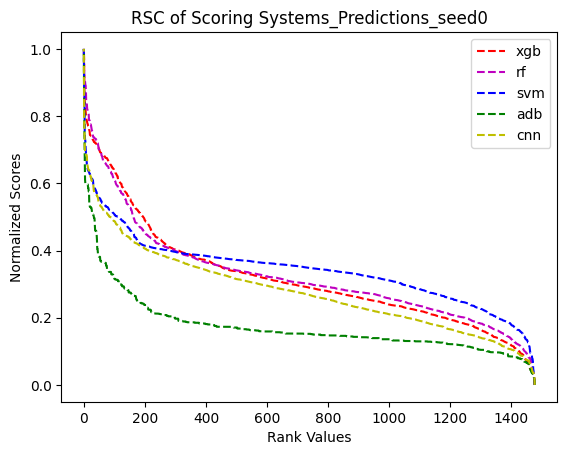

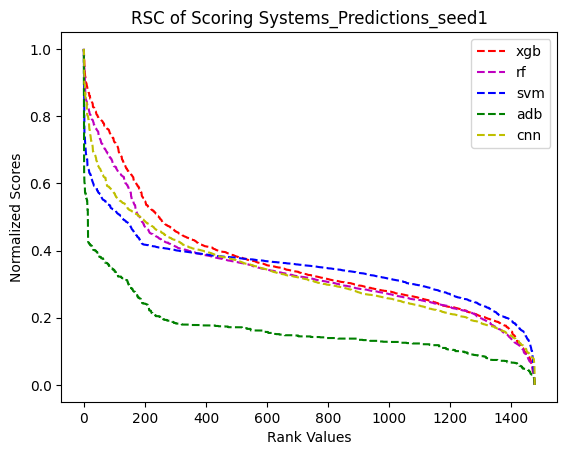

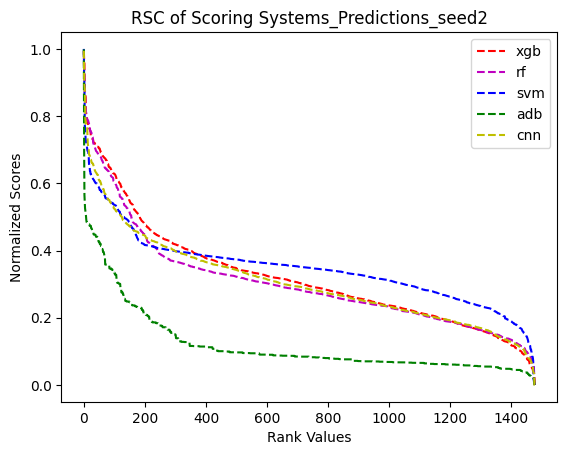

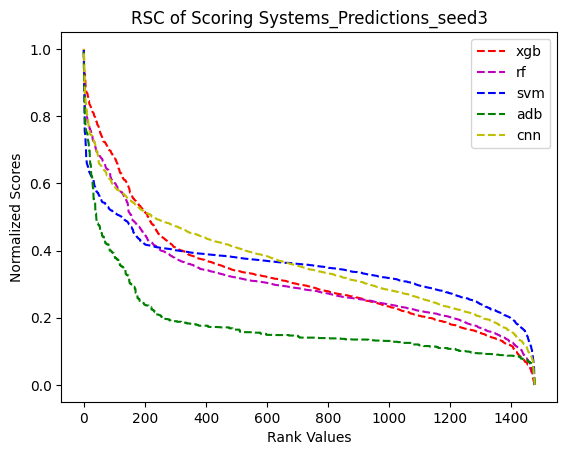

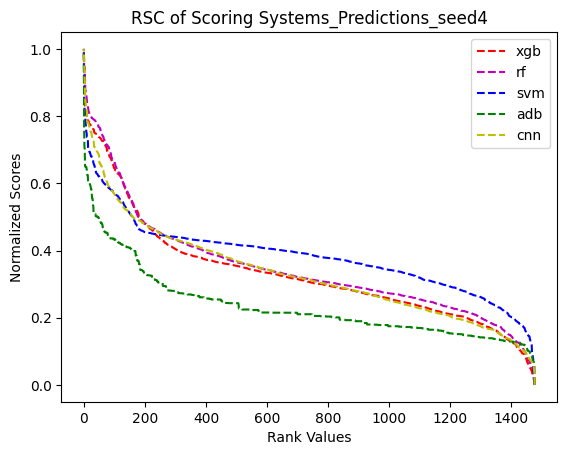

In [ ]:
# RSC graphs
colors = ['r--', 'm--', 'b--', 'g--', 'y--']
ranks = np.flip(np.arange(len(predictions_xgb[0])))

for seed in range(len(globals()['predictions_list_%s' % sys])):
  for z in range(len(scoreSys)):
    globals()['line%s' % (z+1)] = plt.plot(ranks, np.sort(normalize(globals()['predictions_%s' % scoreSys[z]][seed])), colors[z], label = scoreSys[z])
    plt.legend(loc = 'upper right')
    plt.title('RSC of Scoring Systems_Predictions_seed%s' % seed)
    plt.xlabel('Rank Values')
    plt.ylabel('Normalized Scores')
  plt.show()


In [ ]:
ds_score = [[] for _ in range(5)]

In [ ]:
for sys in scoreSys:
  for seed in range(len(ds_score)):
    loc = scoreSys.index(sys)
    scoreSys.remove(sys)
    ds = 0
    for i in range(len(scoreSys)):
      ds += np.sum(np.square(normalize(np.sort(globals()['predictions_%s' % sys][seed]))-normalize(np.sort(globals()['predictions_%s' % scoreSys[i]][seed]))))
    ds = ds/len(scoreSys)
    scoreSys.insert(loc, sys)
    ds_score[seed].append(ds)

In [ ]:
ds_score

[[12.866378500065506,
  12.491391239666244,
  15.797027184862172,
  36.22313947127332,
  9.320613589353552],
 [21.53991737199456,
  15.61926791652612,
  17.7448649291463,
  56.327462289813624,
  14.038970209746537],
 [18.989576171827142,
  15.914788954561853,
  24.233087012851257,
  64.84289922714741,
  15.674718005459845],
 [14.438049673278707,
  11.042055346751173,
  17.909011370884844,
  44.37550216350968,
  17.876289068991234],
 [7.095020248131503,
  7.93437083656526,
  13.860934838325274,
  23.64192715164566,
  6.598181983468804]]

In [ ]:
ds_rank = np.reciprocal(ds_score)

In [ ]:
ds_rank

array([[0.07772195, 0.08005513, 0.06330305, 0.02760666, 0.10728907],
       [0.04642543, 0.06402349, 0.05635433, 0.01775333, 0.0712303 ],
       [0.05266047, 0.06283464, 0.04126589, 0.01542189, 0.063797  ],
       [0.06926143, 0.09056285, 0.05583781, 0.02253496, 0.05594002],
       [0.14094392, 0.12603394, 0.07214521, 0.04229774, 0.1515569 ]])

In [ ]:
def mean_absolute_error(y_pred, y_test):
  res = np.mean(np.abs(y_pred - y_test))
  return res

In [ ]:
ps_score = [[] for _ in range(5)]

In [ ]:
def spearman_corr(y_pred_rank, y_test_rank):
  n = len(y_pred_rank)
  res = 1 - 6 * np.sum((y_pred_rank - y_test_rank)**2) / (n*(n**2-1))
  return res

In [ ]:
for sys in scoreSys:
  for seed in range(len(ps_score)):
    ps = mean_absolute_error(globals()['predictions_%s' % sys][seed], y_test)
    ps_score[seed].append(ps)

In [ ]:
ps_score

[[0.6593135887009471,
  0.6490968245534506,
  0.67163092661705,
  0.77348984229364,
  0.691130244384303],
 [0.67069464864682,
  0.6346616953585927,
  0.676673040947226,
  0.778431657631935,
  0.6996687092016238],
 [0.650585251623816,
  0.6256012644316644,
  0.6695709077401895,
  0.7873557871041948,
  0.6951675112922869],
 [0.6572298075101488,
  0.6360990587483085,
  0.6765542650811908,
  0.7563424493640054,
  0.6987428112313939],
 [0.6385049603518268,
  0.6236204841474966,
  0.6604345024830852,
  0.7812231593572394,
  0.6747017604871448]]

In [ ]:
def powerset(s):
    x = len(s)
    ls = []
    for i in range(1 << x):
        ls.append([s[j] for j in range(x) if (i & (1 << j))])
    return ls[1:]

models = powerset(scoreSys)

def myFunc(e):
  return len(e)

models.sort(key=myFunc)

models_list = []
for i in range(len(models)):
  if len(models[i]) == 1:
    models_list.append(models[i][0])
  elif len(models[i]) == 2:
    models_list.append(models[i][0]+'&'+models[i][1])
  elif len(models[i]) == 3:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2])
  elif len(models[i]) == 4:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3])
  elif len(models[i]) == 5:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3]+'&'+models[i][4])

In [ ]:
models_list

['xgb',
 'rf',
 'svm',
 'adb',
 'cnn',
 'xgb&rf',
 'xgb&svm',
 'rf&svm',
 'xgb&adb',
 'rf&adb',
 'svm&adb',
 'xgb&cnn',
 'rf&cnn',
 'svm&cnn',
 'adb&cnn',
 'xgb&rf&svm',
 'xgb&rf&adb',
 'xgb&svm&adb',
 'rf&svm&adb',
 'xgb&rf&cnn',
 'xgb&svm&cnn',
 'rf&svm&cnn',
 'xgb&adb&cnn',
 'rf&adb&cnn',
 'svm&adb&cnn',
 'xgb&rf&svm&adb',
 'xgb&rf&svm&cnn',
 'xgb&rf&adb&cnn',
 'xgb&svm&adb&cnn',
 'rf&svm&adb&cnn',
 'xgb&rf&svm&adb&cnn']

# Perform average score combinations

In [ ]:
avg_score_combine_seed1 = pd.DataFrame({'xgb':predictions_xgb[0], 'rf':predictions_rf[0], 'svm':predictions_svm[0], 'adb':predictions_adb[0], 'cnn':predictions_cnn[0]})
avg_score_combine_seed2 = pd.DataFrame({'xgb':predictions_xgb[1], 'rf':predictions_rf[1], 'svm':predictions_svm[1], 'adb':predictions_adb[1], 'cnn':predictions_cnn[1]})
avg_score_combine_seed3 = pd.DataFrame({'xgb':predictions_xgb[2], 'rf':predictions_rf[2], 'svm':predictions_svm[2], 'adb':predictions_adb[2], 'cnn':predictions_cnn[2]})
avg_score_combine_seed4 = pd.DataFrame({'xgb':predictions_xgb[3], 'rf':predictions_rf[3], 'svm':predictions_svm[3], 'adb':predictions_adb[3], 'cnn':predictions_cnn[3]})
avg_score_combine_seed5 = pd.DataFrame({'xgb':predictions_xgb[4], 'rf':predictions_rf[4], 'svm':predictions_svm[4], 'adb':predictions_adb[4], 'cnn':predictions_cnn[4]})

In [ ]:
def avg_score_combine(models_list, single_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]+single_score[j.split('&')[4]]) / 5

In [ ]:
avg_score_combine(models_list, avg_score_combine_seed1)
avg_score_combine(models_list, avg_score_combine_seed2)
avg_score_combine(models_list, avg_score_combine_seed3)
avg_score_combine(models_list, avg_score_combine_seed4)
avg_score_combine(models_list, avg_score_combine_seed5)

# Perform average rank combinations

In [ ]:
def score_to_rank(array):
  res = np.argsort(np.flip(np.argsort(array)))+1
  return res

In [ ]:
avg_rank_combine_seed1 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[0]), 'rf':score_to_rank(predictions_rf[0]), 'svm':score_to_rank(predictions_svm[0]), 'adb':score_to_rank(predictions_adb[0]), 'cnn':score_to_rank(predictions_cnn[0])})
avg_rank_combine_seed2 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[1]), 'rf':score_to_rank(predictions_rf[1]), 'svm':score_to_rank(predictions_svm[1]), 'adb':score_to_rank(predictions_adb[1]), 'cnn':score_to_rank(predictions_cnn[1])})
avg_rank_combine_seed3 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[2]), 'rf':score_to_rank(predictions_rf[2]), 'svm':score_to_rank(predictions_svm[2]), 'adb':score_to_rank(predictions_adb[2]), 'cnn':score_to_rank(predictions_cnn[2])})
avg_rank_combine_seed4 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[3]), 'rf':score_to_rank(predictions_rf[3]), 'svm':score_to_rank(predictions_svm[3]), 'adb':score_to_rank(predictions_adb[3]), 'cnn':score_to_rank(predictions_cnn[3])})
avg_rank_combine_seed5 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[4]), 'rf':score_to_rank(predictions_rf[4]), 'svm':score_to_rank(predictions_svm[4]), 'adb':score_to_rank(predictions_adb[4]), 'cnn':score_to_rank(predictions_cnn[4])})

In [ ]:
def avg_rank_combine(models_list, single_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]+single_rank[j.split('&')[4]]) / 5

In [ ]:
avg_rank_combine(models_list, avg_rank_combine_seed1)
avg_rank_combine(models_list, avg_rank_combine_seed2)
avg_rank_combine(models_list, avg_rank_combine_seed3)
avg_rank_combine(models_list, avg_rank_combine_seed4)
avg_rank_combine(models_list, avg_rank_combine_seed5)

# Perform weighted score combination by diversity strength

In [ ]:
ds_score_combine_seed1 = pd.DataFrame()
ds_score_combine_seed2 = pd.DataFrame()
ds_score_combine_seed3 = pd.DataFrame()
ds_score_combine_seed4 = pd.DataFrame()
ds_score_combine_seed5 = pd.DataFrame()

In [ ]:
def ds_score_combine(models_list, single_score, ds_score_combine, ds_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])]+single_score[j.split('&')[4]]*ds_score[scoreSys.index(j.split('&')[4])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])] + ds_score[scoreSys.index(j.split('&')[4])])

In [ ]:
ds_score_combine(models_list, avg_score_combine_seed1, ds_score_combine_seed1, ds_score[0])
ds_score_combine(models_list, avg_score_combine_seed2, ds_score_combine_seed2, ds_score[1])
ds_score_combine(models_list, avg_score_combine_seed3, ds_score_combine_seed3, ds_score[2])
ds_score_combine(models_list, avg_score_combine_seed4, ds_score_combine_seed4, ds_score[3])
ds_score_combine(models_list, avg_score_combine_seed5, ds_score_combine_seed5, ds_score[4])

# Perform weighted rank combination by diversity strength

In [ ]:
ds_rank_combine_seed1 = pd.DataFrame()
ds_rank_combine_seed2 = pd.DataFrame()
ds_rank_combine_seed3 = pd.DataFrame()
ds_rank_combine_seed4 = pd.DataFrame()
ds_rank_combine_seed5 = pd.DataFrame()

In [ ]:
def ds_rank_combine(models_list, single_rank, ds_rank_combine, ds_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])]+single_rank[j.split('&')[4]]*ds_rank[scoreSys.index(j.split('&')[4])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])] + ds_rank[scoreSys.index(j.split('&')[4])])

In [ ]:
ds_rank_combine(models_list, avg_rank_combine_seed1, ds_rank_combine_seed1, ds_rank[0])
ds_rank_combine(models_list, avg_rank_combine_seed2, ds_rank_combine_seed2, ds_rank[1])
ds_rank_combine(models_list, avg_rank_combine_seed3, ds_rank_combine_seed3, ds_rank[2])
ds_rank_combine(models_list, avg_rank_combine_seed4, ds_rank_combine_seed4, ds_rank[3])
ds_rank_combine(models_list, avg_rank_combine_seed5, ds_rank_combine_seed5, ds_rank[4])

# Perform weighted score combination by performance strength (MAE)

In [ ]:
ps_score_combine_seed1 = pd.DataFrame()
ps_score_combine_seed2 = pd.DataFrame()
ps_score_combine_seed3 = pd.DataFrame()
ps_score_combine_seed4 = pd.DataFrame()
ps_score_combine_seed5 = pd.DataFrame()

In [ ]:
def ps_score_combine(models_list, single_score, ps_score_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])])+single_score[j.split('&')[4]]*(1 / ps_score[scoreSys.index(j.split('&')[4])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + 1 / ps_score[scoreSys.index(j.split('&')[3])] + 1 / ps_score[scoreSys.index(j.split('&')[4])])

In [ ]:
ps_score_combine(models_list, avg_score_combine_seed1, ps_score_combine_seed1, ps_score[0])
ps_score_combine(models_list, avg_score_combine_seed2, ps_score_combine_seed2, ps_score[1])
ps_score_combine(models_list, avg_score_combine_seed3, ps_score_combine_seed3, ps_score[2])
ps_score_combine(models_list, avg_score_combine_seed4, ps_score_combine_seed4, ps_score[3])
ps_score_combine(models_list, avg_score_combine_seed5, ps_score_combine_seed5, ps_score[4])

# Perform weighted rank combination by performance strength

In [ ]:
ps_rank_combine_seed1 = pd.DataFrame()
ps_rank_combine_seed2 = pd.DataFrame()
ps_rank_combine_seed3 = pd.DataFrame()
ps_rank_combine_seed4 = pd.DataFrame()
ps_rank_combine_seed5 = pd.DataFrame()

In [ ]:
def ps_rank_combine(models_list, single_rank, ps_rank_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])])+single_rank[j.split('&')[4]]*(ps_score[scoreSys.index(j.split('&')[4])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])] + ps_score[scoreSys.index(j.split('&')[4])])

In [ ]:
ps_rank_combine(models_list, avg_rank_combine_seed1, ps_rank_combine_seed1, ps_score[0])
ps_rank_combine(models_list, avg_rank_combine_seed2, ps_rank_combine_seed2, ps_score[1])
ps_rank_combine(models_list, avg_rank_combine_seed3, ps_rank_combine_seed3, ps_score[2])
ps_rank_combine(models_list, avg_rank_combine_seed4, ps_rank_combine_seed4, ps_score[3])
ps_rank_combine(models_list, avg_rank_combine_seed5, ps_rank_combine_seed5, ps_score[4])

In [ ]:
avg_rank_combine_seed1.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed2.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed3.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed4.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed5.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)

# Calculate MAE

In [ ]:
score_combine_list = np.hstack((np.array(avg_score_combine_seed1.columns), np.array(ds_score_combine_seed1.columns), np.array(ps_score_combine_seed1.columns)))
MAE = pd.DataFrame(index = score_combine_list)
for i in range(1, 6):
  mae_avg, mae_ds, mae_ps = [], [], []
  for col in globals()['avg_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['avg_score_combine_seed%s' %i][col]), y_test)
    mae_avg.append(mae)
  for col in globals()['ds_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['ds_score_combine_seed%s' %i][col]), y_test)
    mae_ds.append(mae)
  for col in globals()['ps_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['ps_score_combine_seed%s' %i][col]), y_test)
    mae_ps.append(mae)
  MAE['seed'+str(i)] = np.hstack((mae_avg, mae_ds, mae_ps))

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
MAE['avg_MAE'] = MAE.mean(axis=1)

In [ ]:
MAE.sort_values(by='avg_MAE')

,seed1,seed2,seed3,seed4,seed5,avg_MAE
rf&cnn_ps,0.636592,0.640291,0.628207,0.642922,0.617751,0.633153
rf&svm&cnn_ps,0.634365,0.641527,0.630022,0.641314,0.619856,0.633417
xgb&rf&cnn_ps,0.636221,0.643387,0.628847,0.641814,0.617204,0.633495
rf,0.649097,0.634662,0.625601,0.636099,0.623620,0.633816
xgb&rf&svm&cnn,0.635566,0.643869,0.630580,0.641212,0.618495,0.633944
rf&svm&cnn,0.634528,0.642386,0.630953,0.642093,0.620356,0.634063
xgb&rf&cnn,0.636432,0.644189,0.629863,0.642565,0.617555,0.634121
rf&cnn,0.637263,0.641819,0.630265,0.644320,0.618900,0.634514
rf&cnn_ds,0.634667,0.640153,0.629953,0.652739,0.616361,0.634774
xgb&rf&cnn_ds,0.636110,0.645310,0.630226,0.647019,0.616635,0.635060


In [ ]:
y_test_rank = score_to_rank(y_test)

spearman_corr_score_func = pd.DataFrame(index = score_combine_list)
for i in range(1, 6):
  sc_score_avg, sc_score_ds, sc_score_ps = [], [], []
  for col in globals()['avg_score_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(score_to_rank(globals()['avg_score_combine_seed%s' %i][col])), y_test_rank)
    sc_score_avg.append(sc)
  for col in globals()['ds_score_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(score_to_rank(globals()['ds_score_combine_seed%s' %i][col])), y_test_rank)
    sc_score_ds.append(sc)
  for col in globals()['ps_score_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(score_to_rank(globals()['ps_score_combine_seed%s' %i][col])), y_test_rank)
    sc_score_ps.append(sc)
  spearman_corr_score_func['seed'+str(i)] = np.hstack((sc_score_avg, sc_score_ds, sc_score_ps))

spearman_corr_score_func['avg_spearman'] = spearman_corr_score_func.mean(axis=1)

spearman_corr_score_func.sort_values(by='avg_spearman',ascending=False)

,seed1,seed2,seed3,seed4,seed5,avg_spearman
rf&svm&cnn_ps,0.622546,0.593293,0.617680,0.615199,0.638972,0.617538
rf&svm,0.601570,0.612373,0.608094,0.619154,0.645999,0.617438
rf&svm_ps,0.601332,0.612654,0.608376,0.619151,0.645652,0.617433
rf&svm&cnn_ds,0.626035,0.594538,0.616667,0.604306,0.645521,0.617413
rf&svm_ds,0.602411,0.611410,0.604989,0.616583,0.646990,0.616476
rf&svm&cnn,0.621711,0.590847,0.616997,0.613340,0.637362,0.616051
xgb&rf&svm&cnn_ps,0.613514,0.581624,0.613278,0.615668,0.640567,0.612930
xgb&rf&svm&cnn,0.613316,0.580117,0.612769,0.614430,0.639796,0.612086
rf&svm&adb&cnn_ps,0.618597,0.586639,0.610605,0.607294,0.633554,0.611338
xgb&rf&svm&cnn_ds,0.613719,0.575646,0.611850,0.608023,0.645954,0.611039


# Calculate Spearman's rank correlation

In [ ]:
y_test_rank = score_to_rank(y_test)

In [ ]:
'''def avg_footrule(y_pred_rank, y_test_rank):
  res = np.mean(np.abs(y_pred_rank - y_test_rank))
  return res'''

'def avg_footrule(y_pred_rank, y_test_rank):\n  res = np.mean(np.abs(y_pred_rank - y_test_rank))\n  return res'

In [ ]:
def get_spearman_corr(y_pred_rank, y_test_rank):
  n = len(y_pred_rank)
  res = 1 - 6 * np.sum((y_pred_rank - y_test_rank)**2) / (n*(n**2-1))
  return res

In [ ]:
rank_combine_list = np.hstack((np.array(avg_rank_combine_seed1.columns), np.array(ds_rank_combine_seed1.columns), np.array(ps_rank_combine_seed1.columns)))
spearman_corr = pd.DataFrame(index = rank_combine_list)
for i in range(1, 6):
  sc_avg, sc_ds, sc_ps = [], [], []
  for col in globals()['avg_rank_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(globals()['avg_rank_combine_seed%s' %i][col]), y_test_rank)
    sc_avg.append(sc)
  for col in globals()['ds_rank_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(globals()['ds_rank_combine_seed%s' %i][col]), y_test_rank)
    sc_ds.append(sc)
  for col in globals()['ps_rank_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(globals()['ps_rank_combine_seed%s' %i][col]), y_test_rank)
    sc_ps.append(sc)
  spearman_corr['seed'+str(i)] = np.hstack((sc_avg, sc_ds, sc_ps))


In [ ]:
pd.set_option("display.max_rows", None)

In [ ]:
spearman_corr['avg_spearman'] = spearman_corr.mean(axis=1)

In [ ]:
spearman_corr.sort_values(by='avg_spearman', ascending=False)

,seed1,seed2,seed3,seed4,seed5,avg_spearman
rf&svm&adb&cnn_ds_r,0.657820,0.630914,0.650735,0.651760,0.672708,0.652787
rf&svm&cnn_r,0.655984,0.630392,0.643973,0.647728,0.673549,0.650325
rf&svm&cnn_ds_r,0.654602,0.629140,0.646035,0.651502,0.667942,0.649844
rf&svm&cnn_ps_r,0.655976,0.628943,0.643650,0.646669,0.672886,0.649625
xgb&rf&svm&adb&cnn_ds_r,0.649725,0.624658,0.646863,0.649379,0.672011,0.648527
xgb&rf&svm&cnn_ds_r,0.647455,0.624223,0.643729,0.649359,0.669492,0.646852
xgb&rf&svm&cnn_r,0.646522,0.621301,0.641830,0.646448,0.673872,0.645995
xgb&rf&svm&cnn_ps_r,0.646836,0.620357,0.641679,0.645793,0.673717,0.645677
rf&adb&cnn_ds_r,0.647268,0.621723,0.648493,0.644502,0.661300,0.644657
xgb&rf&adb&cnn_ds_r,0.641582,0.616972,0.644383,0.643904,0.663987,0.642166
